## Import libraries, methods and constants

In [1]:
import numpy as np
import json
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sn
import cv2
import matplotlib.pyplot as plt
from transformers import AutoModelForSemanticSegmentation
from sklearn.metrics import ConfusionMatrixDisplay
import os
from os import sys

c:\Users\kuian\.conda\envs\master\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
from config import model_types, crops
from constants import weed_plants, weed_plants
from data_prepossessing import create_datasets_for_plants, get_labels
from data_visualization import use_one_channel

## Check if GPU is detected

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use GPU if available, otherwise use a CPU
print(device)

cpu


## Analyse averaged general metrics,
### Such as mean IoU, average and overall accuracies, evalutaion loss and inference time

In [4]:
def load_test_metrics_for_model(model_folder):
    eval_losses = {}
    eval_mean_ious = {}
    eval_mean_accuracies = {}
    eval_overall_accuracies = {}
    eval_per_category_ious = {}
    eval_per_category_accuracies = {}
    eval_runtimes = {}
    eval_samples_per_second = {}
    inference_times = {}

    for model_type in model_types:
        eval_losses[model_type] = {}
        eval_mean_ious[model_type] = {}
        eval_mean_accuracies[model_type] = {}
        eval_overall_accuracies[model_type] = {}
        eval_per_category_ious[model_type] = {}
        eval_per_category_accuracies[model_type] = {}
        eval_runtimes[model_type] = {}
        eval_samples_per_second[model_type] = {}
        inference_times[model_type] = {}

        for crop in crops:
            with open("../" + model_folder + "/" + model_type + "/" + crop + "/test_metric.json", "r") as file:
                data = json.load(file)
                eval_losses[model_type][crop] = data["eval_loss"]
                eval_mean_ious[model_type][crop] = data["eval_mean_iou"]
                eval_mean_accuracies[model_type][crop] = data["eval_mean_accuracy"]
                eval_overall_accuracies[model_type][crop] = data["eval_overall_accuracy"]
                eval_per_category_ious[model_type][crop] = data["eval_per_category_iou"]
                eval_per_category_accuracies[model_type][crop] = data["eval_per_category_accuracy"]
                eval_runtimes[model_type][crop] = data["eval_runtime"]
                eval_samples_per_second[model_type][crop] = data["eval_samples_per_second"]
                inference_times[model_type][crop] = 1 / data["eval_samples_per_second"]

    return (
        eval_losses,
        eval_mean_ious,
        eval_mean_accuracies,
        eval_overall_accuracies,
        eval_per_category_ious,
        eval_per_category_accuracies,
        eval_runtimes,
        eval_samples_per_second,
        inference_times,
    )

In [5]:
(
    s3_eval_losses,
    s3_eval_mean_ious,
    s3_eval_mean_accuracies,
    s3_eval_overall_accuracies,
    s3_eval_per_category_ious,
    s3_eval_per_category_accuracies,
    s3_eval_runtimes,
    s3_eval_samples_per_second,
    s3_inference_times,
) = load_test_metrics_for_model("segformer-models-3-patience")

(
    s5_eval_losses,
    s5_eval_mean_ious,
    s5_eval_mean_accuracies,
    s5_eval_overall_accuracies,
    s5_eval_per_category_ious,
    s5_eval_per_category_accuracies,
    s5_eval_runtimes,
    s5_eval_samples_per_second,
    s5_inference_times,
) = load_test_metrics_for_model("segformer-models-5-patience")

(
    u3_eval_losses,
    u3_eval_mean_ious,
    u3_eval_mean_accuracies,
    u3_eval_overall_accuracies,
    u3_eval_per_category_ious,
    u3_eval_per_category_accuracies,
    u3_eval_runtimes,
    u3_eval_samples_per_second,
    u3_inference_times,
) = load_test_metrics_for_model("upernet-swin-models-3-patience")

(
    u5_eval_losses,
    u5_eval_mean_ious,
    u5_eval_mean_accuracies,
    u5_eval_overall_accuracies,
    u5_eval_per_category_ious,
    u5_eval_per_category_accuracies,
    u5_eval_runtimes,
    u5_eval_samples_per_second,
    u5_inference_times,
) = load_test_metrics_for_model("upernet-swin-models-5-patience")

In [6]:
def print_averaged_metric_value(model_name, metric_values, as_percentage=False):
    if as_percentage:
        binary_eval_loss = np.round(sum(metric_values['binary'].values()) / len(metric_values['binary'].values()) * 100, 2)
        multiclass_eval_loss = np.round(sum(metric_values['multiclass'].values()) / len(metric_values['multiclass'].values()) * 100, 2)
    else:
        binary_eval_loss = np.round(sum(metric_values['binary'].values()) / len(metric_values['binary'].values()), 4)
        multiclass_eval_loss = np.round(sum(metric_values['multiclass'].values()) / len(metric_values['multiclass'].values()), 4)
    
    perc_sign = "%" if as_percentage else ""
    print(f"{model_name} patience binary eval loss:", binary_eval_loss, perc_sign)
    print(f"{model_name} patience multiclass eval loss:", multiclass_eval_loss, perc_sign)

In [7]:
print_averaged_metric_value("Segformer 3", s3_eval_losses)
print_averaged_metric_value("Segformer 5", s5_eval_losses)
print_averaged_metric_value("Upernet Swin Transformer 3", u3_eval_losses)
print_averaged_metric_value("Upernet Swin Transformer 5", u5_eval_losses)

Segformer 3 patience binary eval loss: 0.0568 
Segformer 3 patience multiclass eval loss: 0.0728 
Segformer 5 patience binary eval loss: 0.0132 
Segformer 5 patience multiclass eval loss: 0.0166 
Upernet Swin Transformer 3 patience binary eval loss: 0.0176 
Upernet Swin Transformer 3 patience multiclass eval loss: 0.0271 
Upernet Swin Transformer 5 patience binary eval loss: 0.017 
Upernet Swin Transformer 5 patience multiclass eval loss: 0.023 


In [8]:
print_averaged_metric_value("Segformer 3", s3_eval_mean_ious, as_percentage=True)
print_averaged_metric_value("Segformer 5", s5_eval_mean_ious, as_percentage=True)
print_averaged_metric_value("Upernet Swin Transformer 3", u3_eval_mean_ious, as_percentage=True)
print_averaged_metric_value("Upernet Swin Transformer 5", u5_eval_mean_ious, as_percentage=True)

Segformer 3 patience binary eval loss: 57.85 %
Segformer 3 patience multiclass eval loss: 39.43 %
Segformer 5 patience binary eval loss: 66.31 %
Segformer 5 patience multiclass eval loss: 59.79 %
Upernet Swin Transformer 3 patience binary eval loss: 70.47 %
Upernet Swin Transformer 3 patience multiclass eval loss: 61.98 %
Upernet Swin Transformer 5 patience binary eval loss: 71.69 %
Upernet Swin Transformer 5 patience multiclass eval loss: 65.88 %


In [9]:
print_averaged_metric_value("Segformer 3", s3_eval_mean_accuracies, as_percentage=True)
print_averaged_metric_value("Segformer 5", s5_eval_mean_accuracies, as_percentage=True)
print_averaged_metric_value("Upernet Swin Transformer 3", u3_eval_mean_accuracies, as_percentage=True)
print_averaged_metric_value("Upernet Swin Transformer 5", u5_eval_mean_accuracies, as_percentage=True)

Segformer 3 patience binary eval loss: 62.3 %
Segformer 3 patience multiclass eval loss: 44.48 %
Segformer 5 patience binary eval loss: 70.06 %
Segformer 5 patience multiclass eval loss: 66.03 %
Upernet Swin Transformer 3 patience binary eval loss: 74.05 %
Upernet Swin Transformer 3 patience multiclass eval loss: 69.08 %
Upernet Swin Transformer 5 patience binary eval loss: 75.26 %
Upernet Swin Transformer 5 patience multiclass eval loss: 72.51 %


In [10]:
print_averaged_metric_value("Segformer 3", s3_eval_overall_accuracies, as_percentage=True)
print_averaged_metric_value("Segformer 5", s5_eval_overall_accuracies, as_percentage=True)
print_averaged_metric_value("Upernet Swin Transformer 3", u3_eval_overall_accuracies, as_percentage=True)
print_averaged_metric_value("Upernet Swin Transformer 5", u5_eval_overall_accuracies, as_percentage=True)

Segformer 3 patience binary eval loss: 99.25 %
Segformer 3 patience multiclass eval loss: 98.87 %
Segformer 5 patience binary eval loss: 99.59 %
Segformer 5 patience multiclass eval loss: 99.51 %
Upernet Swin Transformer 3 patience binary eval loss: 99.65 %
Upernet Swin Transformer 3 patience multiclass eval loss: 99.5 %
Upernet Swin Transformer 5 patience binary eval loss: 99.66 %
Upernet Swin Transformer 5 patience multiclass eval loss: 99.56 %


In [11]:
print_averaged_metric_value("Segformer 3", s3_eval_samples_per_second)
print_averaged_metric_value("Segformer 5", s5_eval_samples_per_second)
print_averaged_metric_value("Upernet Swin Transformer 3", u3_eval_samples_per_second)
print_averaged_metric_value("Upernet Swin Transformer 5", u5_eval_samples_per_second)

Segformer 3 patience binary eval loss: 1.2331 
Segformer 3 patience multiclass eval loss: 1.2256 
Segformer 5 patience binary eval loss: 1.2417 
Segformer 5 patience multiclass eval loss: 1.2339 
Upernet Swin Transformer 3 patience binary eval loss: 0.4949 
Upernet Swin Transformer 3 patience multiclass eval loss: 0.3387 
Upernet Swin Transformer 5 patience binary eval loss: 0.4867 
Upernet Swin Transformer 5 patience multiclass eval loss: 0.336 


In [12]:
print_averaged_metric_value("Segformer 3", s3_inference_times)
print_averaged_metric_value("Segformer 5", s5_inference_times)
print_averaged_metric_value("Upernet Swin Transformer 3", u3_inference_times)
print_averaged_metric_value("Upernet Swin Transformer 5", u5_inference_times)

Segformer 3 patience binary eval loss: 0.8111 
Segformer 3 patience multiclass eval loss: 0.8163 
Segformer 5 patience binary eval loss: 0.8054 
Segformer 5 patience multiclass eval loss: 0.8105 
Upernet Swin Transformer 3 patience binary eval loss: 2.0224 
Upernet Swin Transformer 3 patience multiclass eval loss: 4.391 
Upernet Swin Transformer 5 patience binary eval loss: 2.056 
Upernet Swin Transformer 5 patience multiclass eval loss: 4.1675 


## Analyse per crop model general metrics
### Such as mean IoU, average and overall accuracies, evalutaion loss and inference time

In [13]:
def print_rounded_per_crop_and_model_metric(metric_dictionary, as_percentage=False):
    for key1, inner_dict in metric_dictionary.items():
        print(f"'{key1}': ")
        for key2, value in inner_dict.items():
            if as_percentage:
                percent_value = round(value * 100, 2)
                print(f"    '{key2}': {percent_value}%,")
            else:
                rounded_value = round(value, 4)
                print(f"    '{key2}': {rounded_value},")
        print(" ")

In [14]:
print("mIoU:")
print_rounded_per_crop_and_model_metric(s3_eval_mean_ious, as_percentage=True)
print_rounded_per_crop_and_model_metric(s5_eval_mean_ious, as_percentage=True)
print_rounded_per_crop_and_model_metric(u3_eval_mean_ious, as_percentage=True)
print_rounded_per_crop_and_model_metric(u5_eval_mean_ious, as_percentage=True)

mIoU:
'binary': 
    'broad_bean': 65.43%,
    'common_buckwheat': 66.8%,
    'pea': 44.84%,
    'corn': 60.74%,
    'soybean': 35.19%,
    'sunflower': 67.16%,
    'sugar_beet': 64.79%,
 
'multiclass': 
    'broad_bean': 60.61%,
    'common_buckwheat': 25.57%,
    'pea': 46.4%,
    'corn': 59.21%,
    'soybean': 24.1%,
    'sunflower': 39.42%,
    'sugar_beet': 20.67%,
 
'binary': 
    'broad_bean': 67.31%,
    'common_buckwheat': 65.55%,
    'pea': 64.14%,
    'corn': 65.73%,
    'soybean': 68.28%,
    'sunflower': 68.18%,
    'sugar_beet': 64.95%,
 
'multiclass': 
    'broad_bean': 60.63%,
    'common_buckwheat': 61.53%,
    'pea': 56.65%,
    'corn': 59.4%,
    'soybean': 59.24%,
    'sunflower': 61.05%,
    'sugar_beet': 60.0%,
 
'binary': 
    'broad_bean': 74.45%,
    'common_buckwheat': 74.2%,
    'pea': 68.47%,
    'corn': 68.34%,
    'soybean': 69.29%,
    'sunflower': 70.88%,
    'sugar_beet': 67.65%,
 
'multiclass': 
    'broad_bean': 60.52%,
    'common_buckwheat': 65.01%,

In [15]:
print("Average Accuracy:")
print_rounded_per_crop_and_model_metric(s3_eval_mean_accuracies, as_percentage=True)
print_rounded_per_crop_and_model_metric(s5_eval_mean_accuracies, as_percentage=True)
print_rounded_per_crop_and_model_metric(u3_eval_mean_accuracies, as_percentage=True)
print_rounded_per_crop_and_model_metric(u5_eval_mean_accuracies, as_percentage=True)

Average Accuracy:
'binary': 
    'broad_bean': 69.38%,
    'common_buckwheat': 70.15%,
    'pea': 47.42%,
    'corn': 67.11%,
    'soybean': 42.41%,
    'sunflower': 70.43%,
    'sugar_beet': 69.16%,
 
'multiclass': 
    'broad_bean': 66.33%,
    'common_buckwheat': 27.82%,
    'pea': 53.34%,
    'corn': 65.06%,
    'soybean': 27.9%,
    'sunflower': 44.7%,
    'sugar_beet': 26.19%,
 
'binary': 
    'broad_bean': 71.31%,
    'common_buckwheat': 68.71%,
    'pea': 68.86%,
    'corn': 70.23%,
    'soybean': 71.21%,
    'sunflower': 71.13%,
    'sugar_beet': 68.94%,
 
'multiclass': 
    'broad_bean': 66.32%,
    'common_buckwheat': 67.23%,
    'pea': 64.18%,
    'corn': 65.89%,
    'soybean': 64.31%,
    'sunflower': 67.1%,
    'sugar_beet': 67.15%,
 
'binary': 
    'broad_bean': 77.86%,
    'common_buckwheat': 78.11%,
    'pea': 73.86%,
    'corn': 71.75%,
    'soybean': 72.3%,
    'sunflower': 73.78%,
    'sugar_beet': 70.71%,
 
'multiclass': 
    'broad_bean': 66.73%,
    'common_buckw

In [16]:
print("Overall Accuracy:")
print_rounded_per_crop_and_model_metric(s3_eval_overall_accuracies, as_percentage=True)
print_rounded_per_crop_and_model_metric(s5_eval_overall_accuracies, as_percentage=True)
print_rounded_per_crop_and_model_metric(u3_eval_overall_accuracies, as_percentage=True)
print_rounded_per_crop_and_model_metric(u5_eval_overall_accuracies, as_percentage=True)

Overall Accuracy:
'binary': 
    'broad_bean': 99.5%,
    'common_buckwheat': 99.57%,
    'pea': 99.17%,
    'corn': 99.35%,
    'soybean': 98.05%,
    'sunflower': 99.57%,
    'sugar_beet': 99.53%,
 
'multiclass': 
    'broad_bean': 99.55%,
    'common_buckwheat': 98.39%,
    'pea': 99.2%,
    'corn': 99.51%,
    'soybean': 98.4%,
    'sunflower': 98.99%,
    'sugar_beet': 98.07%,
 
'binary': 
    'broad_bean': 99.6%,
    'common_buckwheat': 99.56%,
    'pea': 99.64%,
    'corn': 99.57%,
    'soybean': 99.65%,
    'sunflower': 99.61%,
    'sugar_beet': 99.53%,
 
'multiclass': 
    'broad_bean': 99.55%,
    'common_buckwheat': 99.52%,
    'pea': 99.48%,
    'corn': 99.53%,
    'soybean': 99.53%,
    'sunflower': 99.52%,
    'sugar_beet': 99.46%,
 
'binary': 
    'broad_bean': 99.69%,
    'common_buckwheat': 99.66%,
    'pea': 99.66%,
    'corn': 99.65%,
    'soybean': 99.66%,
    'sunflower': 99.64%,
    'sugar_beet': 99.57%,
 
'multiclass': 
    'broad_bean': 99.49%,
    'common_buckw

In [17]:
print("Evaluation Loss:")
print_rounded_per_crop_and_model_metric(s3_eval_losses)
print_rounded_per_crop_and_model_metric(s5_eval_losses)
print_rounded_per_crop_and_model_metric(u3_eval_losses)
print_rounded_per_crop_and_model_metric(u5_eval_losses)

Evaluation Loss:
'binary': 
    'broad_bean': 0.0246,
    'common_buckwheat': 0.0144,
    'pea': 0.0329,
    'corn': 0.0277,
    'soybean': 0.2664,
    'sunflower': 0.0157,
    'sugar_beet': 0.0163,
 
'multiclass': 
    'broad_bean': 0.0189,
    'common_buckwheat': 0.0779,
    'pea': 0.0282,
    'corn': 0.0174,
    'soybean': 0.1835,
    'sunflower': 0.0484,
    'sugar_beet': 0.1357,
 
'binary': 
    'broad_bean': 0.0146,
    'common_buckwheat': 0.016,
    'pea': 0.0103,
    'corn': 0.014,
    'soybean': 0.0105,
    'sunflower': 0.0124,
    'sugar_beet': 0.0145,
 
'multiclass': 
    'broad_bean': 0.0188,
    'common_buckwheat': 0.0156,
    'pea': 0.017,
    'corn': 0.016,
    'soybean': 0.0158,
    'sunflower': 0.0152,
    'sugar_beet': 0.0175,
 
'binary': 
    'broad_bean': 0.0157,
    'common_buckwheat': 0.0168,
    'pea': 0.0167,
    'corn': 0.0176,
    'soybean': 0.0169,
    'sunflower': 0.0182,
    'sugar_beet': 0.0214,
 
'multiclass': 
    'broad_bean': 0.0269,
    'common_buckwh

In [18]:
print("Samples per second:")
print_rounded_per_crop_and_model_metric(s3_eval_samples_per_second)
print_rounded_per_crop_and_model_metric(s5_eval_samples_per_second)
print_rounded_per_crop_and_model_metric(u3_eval_samples_per_second)
print_rounded_per_crop_and_model_metric(u5_eval_samples_per_second)

Samples per second:
'binary': 
    'broad_bean': 1.216,
    'common_buckwheat': 1.251,
    'pea': 1.246,
    'corn': 1.239,
    'soybean': 1.2,
    'sunflower': 1.241,
    'sugar_beet': 1.239,
 
'multiclass': 
    'broad_bean': 1.224,
    'common_buckwheat': 1.254,
    'pea': 1.257,
    'corn': 1.238,
    'soybean': 1.177,
    'sunflower': 1.21,
    'sugar_beet': 1.219,
 
'binary': 
    'broad_bean': 1.25,
    'common_buckwheat': 1.256,
    'pea': 1.253,
    'corn': 1.223,
    'soybean': 1.22,
    'sunflower': 1.251,
    'sugar_beet': 1.239,
 
'multiclass': 
    'broad_bean': 1.246,
    'common_buckwheat': 1.248,
    'pea': 1.237,
    'corn': 1.227,
    'soybean': 1.215,
    'sunflower': 1.233,
    'sugar_beet': 1.231,
 
'binary': 
    'broad_bean': 0.512,
    'common_buckwheat': 0.498,
    'pea': 0.48,
    'corn': 0.514,
    'soybean': 0.479,
    'sunflower': 0.5,
    'sugar_beet': 0.481,
 
'multiclass': 
    'broad_bean': 0.499,
    'common_buckwheat': 0.507,
    'pea': 0.489,
    'c

In [19]:
print("Inference time:")
print_rounded_per_crop_and_model_metric(s3_inference_times)
print_rounded_per_crop_and_model_metric(s5_inference_times)
print_rounded_per_crop_and_model_metric(u3_inference_times)
print_rounded_per_crop_and_model_metric(u5_inference_times)

Inference time:
'binary': 
    'broad_bean': 0.8224,
    'common_buckwheat': 0.7994,
    'pea': 0.8026,
    'corn': 0.8071,
    'soybean': 0.8333,
    'sunflower': 0.8058,
    'sugar_beet': 0.8071,
 
'multiclass': 
    'broad_bean': 0.817,
    'common_buckwheat': 0.7974,
    'pea': 0.7955,
    'corn': 0.8078,
    'soybean': 0.8496,
    'sunflower': 0.8264,
    'sugar_beet': 0.8203,
 
'binary': 
    'broad_bean': 0.8,
    'common_buckwheat': 0.7962,
    'pea': 0.7981,
    'corn': 0.8177,
    'soybean': 0.8197,
    'sunflower': 0.7994,
    'sugar_beet': 0.8071,
 
'multiclass': 
    'broad_bean': 0.8026,
    'common_buckwheat': 0.8013,
    'pea': 0.8084,
    'corn': 0.815,
    'soybean': 0.823,
    'sunflower': 0.811,
    'sugar_beet': 0.8123,
 
'binary': 
    'broad_bean': 1.9531,
    'common_buckwheat': 2.008,
    'pea': 2.0833,
    'corn': 1.9455,
    'soybean': 2.0877,
    'sunflower': 2.0,
    'sugar_beet': 2.079,
 
'multiclass': 
    'broad_bean': 2.004,
    'common_buckwheat': 1.97

## Analyze training and evaluation runtimes, the number of epochs and training and validation losses

In [20]:
def preprocess_model_performance_info_for_model(model_folder):
    train_runtimes = {}
    eval_runtimes = {}
    epochs = {}
    total_train_loss = {}
    train_losses = {}
    eval_losses = {}

    for model_type in model_types:
        train_runtimes[model_type] = {}
        eval_runtimes[model_type] = {}
        epochs[model_type] = {}
        total_train_loss[model_type] = {}
        train_losses[model_type] = {}
        eval_losses[model_type] = {}

        for crop in crops:
            with open('../' + model_folder + '/' + model_type + '/' + crop + '/log_history.json', 'r') as file:
                data = json.load(file)
                
                train_runtimes[model_type][crop] = data[-1]['train_runtime']
                epochs[model_type][crop] = data[-1]['epoch']

                eval_runtimes[model_type][crop] = []
                train_losses[model_type][crop] = []
                eval_losses[model_type][crop] = []
                for entry in data:
                    if 'eval_runtime' in entry.keys():
                        eval_runtimes[model_type][crop].append(entry['eval_runtime'])

                    if 'eval_loss' in entry.keys():
                        eval_losses[model_type][crop].append(entry['eval_loss'])

                    if 'loss' in entry.keys():
                        train_losses[model_type][crop].append(entry['loss'])

                    if 'train_loss' in entry.keys():
                        total_train_loss[model_type][crop] = entry['train_loss']

    return train_runtimes, eval_runtimes, epochs, total_train_loss, train_losses, eval_losses

In [21]:
def compute_general_numeric_statistics(train_runtimes, eval_runtimes, epochs, train_losses, eval_losses):
    train_runtime_total = 0
    eval_runtime_total = 0

    train_runtime_per_model_type = {}
    eval_runtime_per_model_type = {}

    for model_type in model_types:
        train_runtime_per_model_type[model_type] = 0
        eval_runtime_per_model_type[model_type] = 0

        for crop in crops:
            train_runtime_total = train_runtime_total + train_runtimes[model_type][crop]
            eval_runtime_total = eval_runtime_total + sum(eval_runtimes[model_type][crop])

            train_runtime_per_model_type[model_type] = train_runtime_per_model_type[model_type] + train_runtimes[model_type][crop]
            eval_runtime_per_model_type[model_type] = eval_runtime_per_model_type[model_type] + sum(eval_runtimes[model_type][crop])
        
    print('Total training time in h: ' + str(np.round(train_runtime_total/60/60, 2)))
    print('Total evaluation time in h: ' + str(np.round(eval_runtime_total/60/60, 2)))

    print('Training time for binary models : ' + str(np.round(train_runtime_per_model_type['binary']/60/60, 2)))
    print('Training time for multiclass models : ' + str(np.round(train_runtime_per_model_type['multiclass']/60/60, 2)))
    print('Evaluation time for binary models : ' + str(np.round(eval_runtime_per_model_type['binary']/60/60, 2)))
    print('Evaluation time for multiclass models : ' + str(np.round(eval_runtime_per_model_type['multiclass']/60/60, 2)))

In [22]:
def plot_bar_chart(data, title, store_filename = None):
    # Extract the labels and values for the 'binary' and 'multiclass' categories
    crops = list(data['binary'].keys())
    binary_values = [data['binary'][crop] for crop in crops]
    multiclass_values = [data['multiclass'][crop] for crop in crops]

    # Set the width of the bars
    bar_width = 0.35
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create bar positions for each category
    x = range(len(crops))

    # Plot the 'binary' values
    plt.bar(x, binary_values, width=bar_width, label='Binary', align='center')

    # Plot the 'multiclass' values with an offset
    plt.bar([i + bar_width for i in x], multiclass_values, width=bar_width, label='Multiclass', align='center')

    plt.title(title)
    crop_labels = [crop.replace("_", " ") for crop in crops]
    plt.xticks([i + bar_width / 2 for i in x], crop_labels, rotation=45)

    plt.legend()
    plt.tight_layout()
    if store_filename:
        plt.savefig(store_filename)

    plt.show()

In [23]:
def plot_line_graph(data, title, store_filename = None):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Loop through the categories and items to plot lines
    for category, item_data in data.items():
        for item, values in item_data.items():
            label = f'{category} - {item}'
            x = np.arange(len(values))
            ax.plot(x*30, values, label=label)

    ax.set_xlabel('Steps')
    ax.set_ylabel('Values')

    plt.title(title)
    ax.legend()
    plt.tight_layout()

    if store_filename:
        plt.savefig(store_filename)

    plt.show()

In [24]:
plt.rcParams.update({'font.size': 14})

### Segformer models with early stopping patience of 3

In [25]:
(
    train_runtimes, 
    eval_runtimes,
    epochs,
    total_train_loss,
    train_losses,
    eval_losses,
) = preprocess_model_performance_info_for_model("segformer-models-3-patience")

In [26]:
compute_general_numeric_statistics(train_runtimes, eval_runtimes, epochs, train_losses, eval_losses)

Total training time in h: 15.73
Total evaluation time in h: 7.56
Training time for binary models : 8.35
Training time for multiclass models : 7.37
Evaluation time for binary models : 4.0
Evaluation time for multiclass models : 3.56


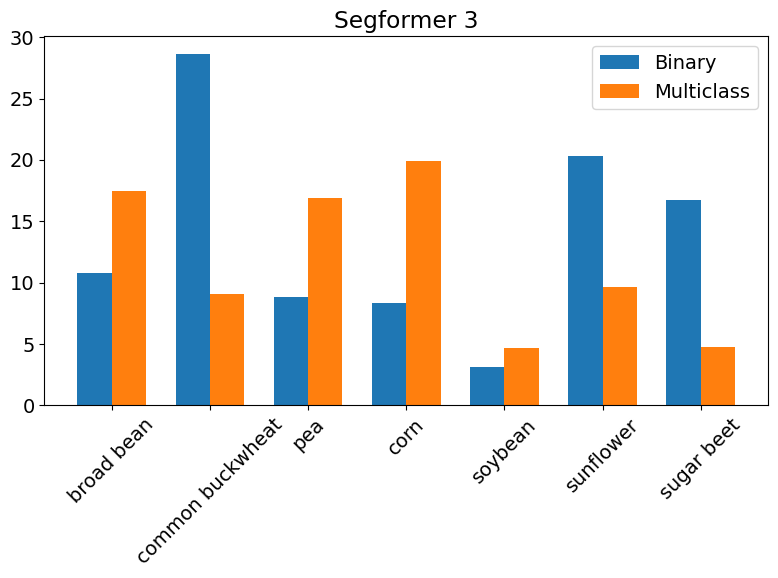

In [27]:
# plot_bar_chart(train_runtimes, "Training Time per Model Type and Crop", "../model_performance_plots/segformer_3_train_times")
plot_bar_chart(epochs, "Segformer 3", "../model_performance_plots/segformer_3_epochs")

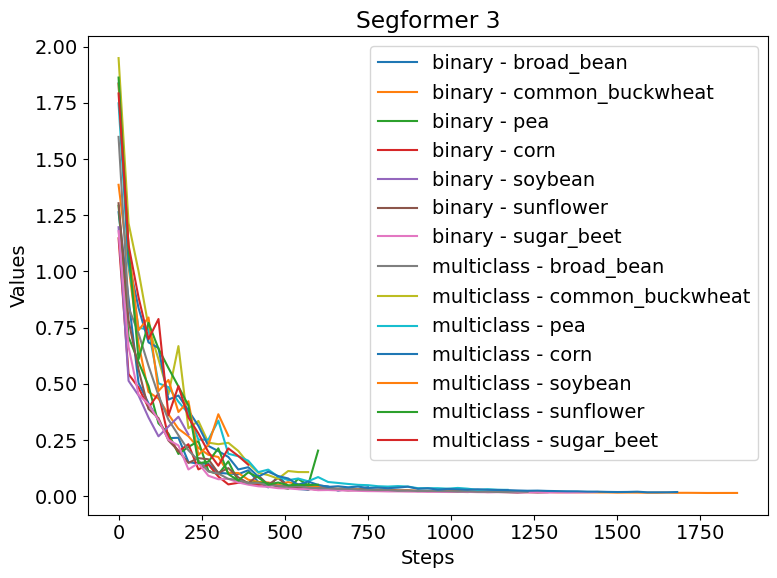

In [28]:
plot_line_graph(eval_losses, "Segformer 3", "../model_performance_plots/segformer_3_eval_losses")

### Segformer models with early stopping patience of 5

In [29]:
(
    train_runtimes, 
    eval_runtimes,
    epochs,
    total_train_loss,
    train_losses,
    eval_losses,
) = preprocess_model_performance_info_for_model("segformer-models-5-patience")

In [30]:
compute_general_numeric_statistics(train_runtimes, eval_runtimes, epochs, train_losses, eval_losses)

Total training time in h: 32.82
Total evaluation time in h: 15.77
Training time for binary models : 16.15
Training time for multiclass models : 16.67
Evaluation time for binary models : 7.74
Evaluation time for multiclass models : 8.03


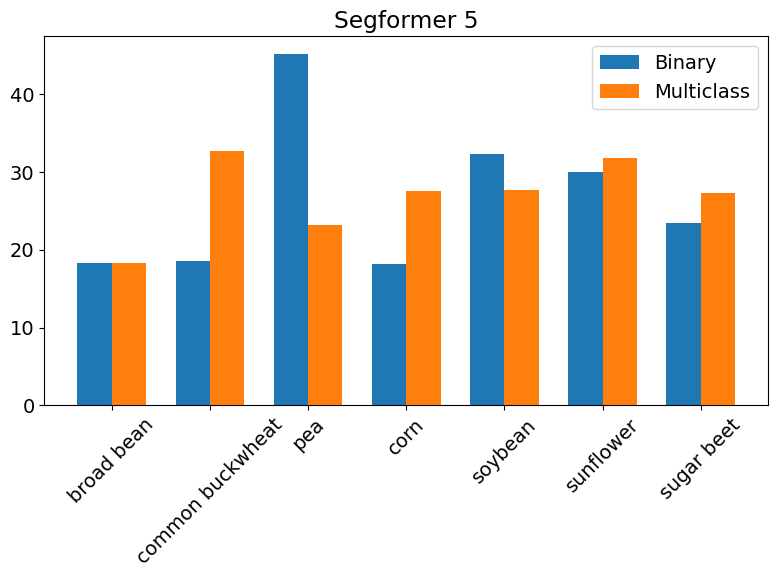

In [31]:
# plot_bar_chart(train_runtimes, 'Training Time per Model Type and Crop', "../model_performance_plots/segformer_5_train_times")
# plot_heat_map(total_train_loss, 'Train Loss Heatmap per Model Type and Crop')
# plot_line_graph(train_losses, 'Train Loss per Model Type and Crop')
plot_bar_chart(epochs, "Segformer 5", "../model_performance_plots/segformer_5_epochs")

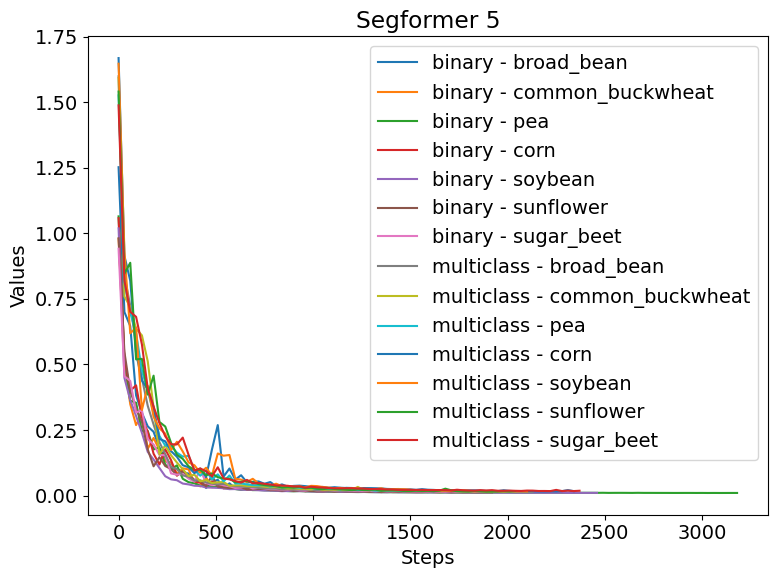

In [32]:
plot_line_graph(eval_losses, "Segformer 5", "../model_performance_plots/segformer_5_eval_losses")

### Upernet  models with early stopping patience of 3

In [33]:
(
    train_runtimes,
    eval_runtimes,
    epochs,
    total_train_loss,
    train_losses,
    eval_losses,
) = preprocess_model_performance_info_for_model("upernet-swin-models-3-patience")

In [34]:
compute_general_numeric_statistics(train_runtimes, eval_runtimes, epochs, train_losses, eval_losses)

Total training time in h: 20.54
Total evaluation time in h: 10.35
Training time for binary models : 13.44
Training time for multiclass models : 7.1
Evaluation time for binary models : 6.77
Evaluation time for multiclass models : 3.58


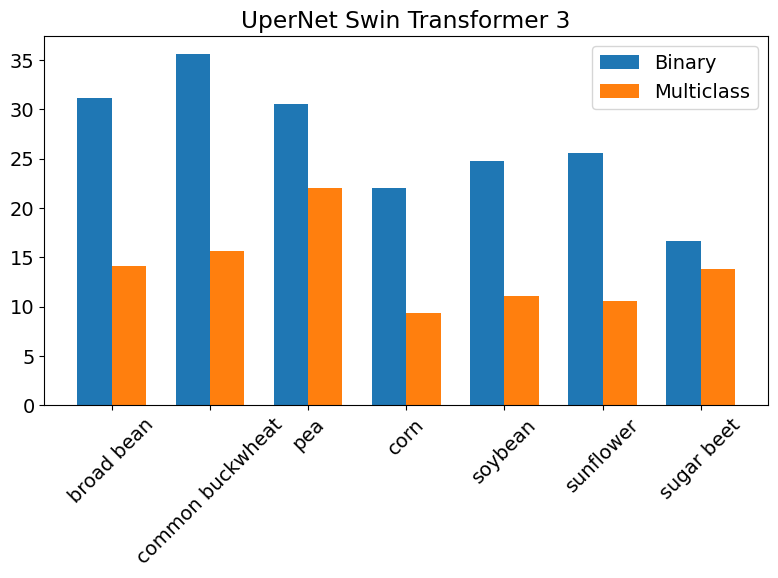

In [35]:
# plot_heat_map(total_train_loss, 'Train Loss Heatmap per Model Type and Crop')
# plot_line_graph(train_losses, 'Train Loss per Model Type and Crop')
plot_bar_chart(epochs, "UperNet Swin Transformer 3", "../model_performance_plots/upernet_3_epochs")

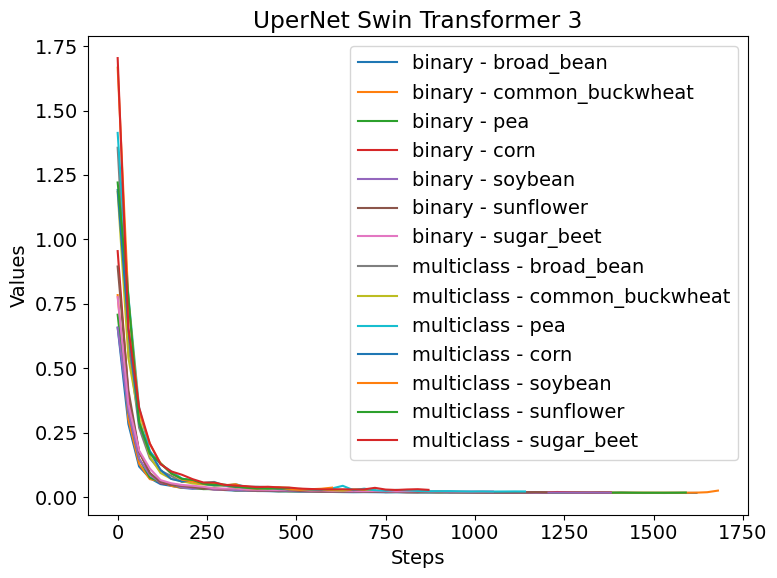

In [36]:
plot_line_graph(eval_losses, "UperNet Swin Transformer 3", "../model_performance_plots/upernet_3_eval_losses")

### Upernet  models with early stopping patience of 5

In [37]:
(
    train_runtimes,
    eval_runtimes,
    epochs,
    total_train_loss,
    train_losses,
    eval_losses,
) = preprocess_model_performance_info_for_model("upernet-swin-models-5-patience")

In [38]:
compute_general_numeric_statistics(train_runtimes, eval_runtimes, epochs, train_losses, eval_losses)

Total training time in h: 28.42
Total evaluation time in h: 14.29
Training time for binary models : 17.55
Training time for multiclass models : 10.87
Evaluation time for binary models : 8.81
Evaluation time for multiclass models : 5.48


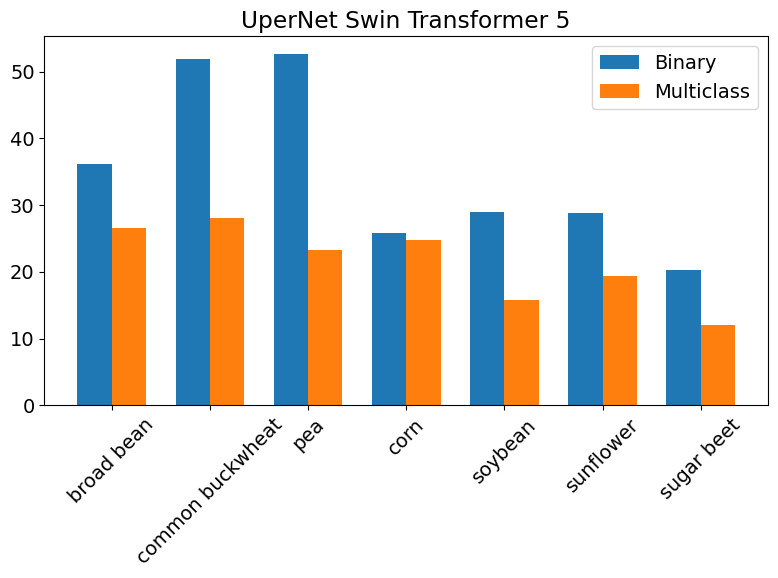

In [39]:
plot_bar_chart(epochs, "UperNet Swin Transformer 5", "../model_performance_plots/upernet_5_epochs")

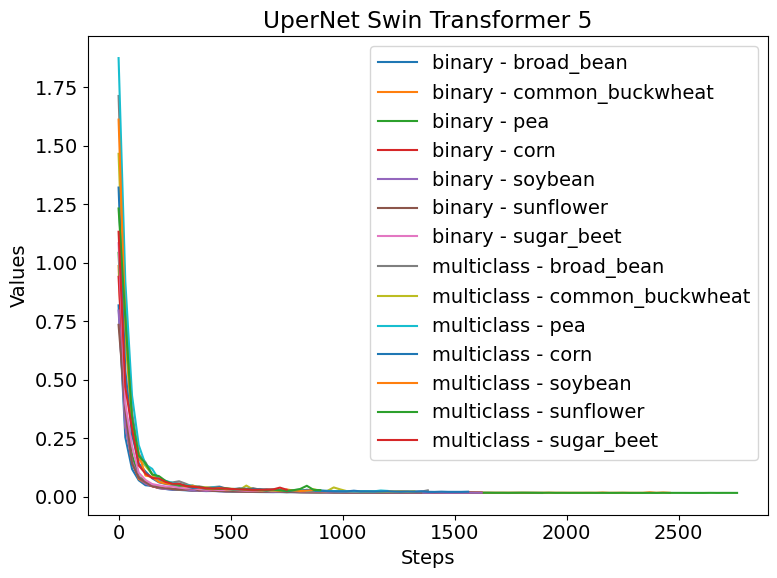

In [40]:
plot_line_graph(eval_losses, "UperNet Swin Transformer 5", "../model_performance_plots/upernet_5_eval_losses")

In [41]:
# def plot_heat_map(data, title):
#     categories = list(data.keys())

#     # Convert the data to a NumPy array
#     heatmap_data = np.array([[data[category][crop] for crop in crops] for category in categories])

#     fig, ax = plt.subplots(figsize=(10, 6))
#     # Create the heatmap
#     cax = ax.matshow(heatmap_data, cmap='viridis')

#     # Add colorbar
#     cbar = fig.colorbar(cax)

#     # Set labels for the x and y axes
#     labels = [crop.replace("_", " ") for crop in list(data['binary'].keys())]
    
#     ax.set_xticks(np.arange(len(labels)))
#     ax.set_yticks(np.arange(len(categories)))
#     ax.set_xticklabels(labels, rotation=45, ha='right')
#     ax.set_yticklabels(categories)

#     # Show the values in each cell
#     # for i in range(len(categories)):
#     #     for j in range(len(items)):
#     #         text = ax.text(j, i, f'{heatmap_data[i, j]:.2f}', ha='center', va='center', color='w', fontsize=8)  # Specify fontsize
#     plt.title('Heatmap of Values for Different Categories and Items')
#     plt.tight_layout()
#     plt.show()

## Predict test instances

In [42]:
segformer_checkpoint = "nvidia/mit-b0"
upernet_swin_checkpoint = "openmmlab/upernet-swin-tiny"

In [43]:
from transformers import AutoImageProcessor
segformer_image_processor = AutoImageProcessor.from_pretrained(segformer_checkpoint)
upernet_swin_image_processor = AutoImageProcessor.from_pretrained(upernet_swin_checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
c:\Users\kuian\.conda\envs\master\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [44]:
def get_test_data(crop, model_type):
    model_plant_names = [crop] + weed_plants
    train_ds, test_ds = create_datasets_for_plants(model_plant_names, model_type, crop)

    return test_ds

In [45]:
def get_model(crop, model_type, models_folder):
    id2label, label2id = get_labels(crop, model_type)

    checkpoint = models_folder + model_type + '/' + crop + '/'
    model = AutoModelForSemanticSegmentation.from_pretrained(checkpoint, id2label=id2label, label2id=label2id)
    model.to(device)

    return model

In [46]:
def pred_segm_mask(image, image_processor, device, model):
    encoding = image_processor(image, return_tensors="pt")
    pixel_values = encoding.pixel_values.to(device)

    outputs = model(pixel_values=pixel_values)

    logits = outputs.logits.cpu()

    upsampled_logits = torch.nn.functional.interpolate(
        logits,
        size=image.size[::-1],
        mode="bilinear",
        align_corners=False,
    )

    pred_seg = upsampled_logits.argmax(dim=1)[0]
    return pred_seg.detach().cpu().numpy()

In [47]:
def compute_predictions(image_processor, models_folder):
    for crop in crops:
        test_ds = get_test_data(crop, 'binary')

        for model_type in model_types:
            model = get_model(crop, model_type, ".." + models_folder)

            for test_ds_entry in test_ds:
                folder_path = "../predictions/" + models_folder + "/" + model_type + "/" + crop + "/"
                if not os.path.exists(folder_path):
                    os.makedirs(folder_path)

                if not os.path.isfile(folder_path):
                    pred_seg = pred_segm_mask(test_ds_entry["image"], image_processor, device, model)
                    cv2.imwrite(folder_path + test_ds_entry["image_name"], pred_seg)

In [48]:
# compute_predictions(segformer_image_processor, '/segformer-models-3-patience/')
# compute_predictions(segformer_image_processor, '/segformer-models-5-patience/')
# compute_predictions(upernet_swin_image_processor, '/upernet-swin-models-3-patience/')
# compute_predictions(upernet_swin_image_processor, '/upernet-swin-models-5-patience/')

## Build confusion matrices

In [49]:
binary_base_conf_m = confusion_matrix([0,1,2,3], [0,1,2,3], labels=[0,1,2,3])

for trained_models_folder in ["segformer-models-3-patience", "segformer-models-5-patience", "upernet-swin-models-3-patience", "upernet-swin-models-5-patience"]:
    model_type = "binary"
    for crop in crops:
        conf_m_file_path = "../confusion_matrices/" + trained_models_folder + "/" + model_type + "_" + crop + "_conf_m.npy"
        if not os.path.exists(conf_m_file_path):
            test_ds = get_test_data(crop, model_type)
            cm = binary_base_conf_m

            for image_name in test_ds["image_name"]:
                y_pred = use_one_channel(cv2.imread("../predictions/" + trained_models_folder + "/" + model_type + "/" + crop + "/" + image_name)).flatten()
                y_true = use_one_channel(cv2.imread("../WE3DS/annotations_binary/" + crop + "/"  + image_name)).flatten()
                im_cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
                cm = cm + im_cm
            
            cm = cm - binary_base_conf_m
                
            with open(conf_m_file_path, "w") as file:
                np.save(conf_m_file_path, cm)

In [50]:
example_conf_m_1 = np.load("../confusion_matrices/segformer-models-3-patience/binary_broad_bean_conf_m.npy")
example_conf_m_1

array([[        0,    157825,      3103,     24038],
       [        0, 766074175,    210458,   1479130],
       [        0,    187667,   3919084,    112570],
       [        0,   1667905,     18136,   9557109]], dtype=int64)

In [51]:
multiclass_base_conf_m = confusion_matrix([0,1,2,3,4,5,6,7], [0,1,2,3,4,5,6,7], labels=[0,1,2,3,4,5,6,7])

for trained_models_folder in ["segformer-models-3-patience", "segformer-models-5-patience", "upernet-swin-models-3-patience", "upernet-swin-models-5-patience"]:
    model_type = "multiclass"
    for crop in crops:
        conf_m_file_path = "../confusion_matrices/" + trained_models_folder + "/" + model_type + "_" + crop + "_conf_m.npy"
        if not os.path.exists(conf_m_file_path):
            test_ds = get_test_data(crop, model_type)
            cm = multiclass_base_conf_m

            for image_name in test_ds["image_name"]:
                y_pred = use_one_channel(cv2.imread("../predictions/" + trained_models_folder + "/" + model_type + "/" + crop + "/" + image_name)).flatten()
                y_true = use_one_channel(cv2.imread("../WE3DS/annotations_multiclass/" + crop + "/"  + image_name)).flatten()
                im_cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4,5,6,7])
                cm = cm + im_cm
            
            cm = cm - multiclass_base_conf_m
                
            with open(conf_m_file_path, "w") as file:
                np.save(conf_m_file_path, cm)

In [52]:
example_conf_m_2 = np.load("../confusion_matrices/segformer-models-3-patience/multiclass_broad_bean_conf_m.npy")
print(example_conf_m_2)

[[        0    153685      8096      5623      7831      2703      7028
          0]
 [        0 766375265    220419    329568    475395    204231    158885
          0]
 [        0     74679   4122363         0     20933      1346         0
          0]
 [        0    410374       516   2279310    282388      3103      4598
          0]
 [        0    377569      1363     34638   3094635         0         0
          0]
 [        0     79269         0       148      3564   2935466        66
          0]
 [        0    415246         0     16636       485         0   1086451
          0]
 [        0    132922         0     54041      1494     27391      1477
          0]]


In [53]:
example_conf_m_2 = np.array(
    [
        [12, 3, 4, 1, 2, 0, 0, 1],
        [1, 22, 0, 1, 0, 1, 0, 0],
        [2, 3, 10, 4, 1, 1, 1, 0],
        [0, 1, 2, 8, 1, 0, 0, 2],
        [1, 0, 0, 0, 9, 1, 1, 0],
        [0, 0, 1, 0, 0, 7, 2, 0],
        [0, 0, 0, 0, 0, 2, 6, 0],
        [1, 0, 0, 2, 0, 0, 0, 9],
    ]
)
print(example_conf_m_2)

# Combine the "weed 1" to "weed 5" counts into a single "weed" class
reduced_confusion_matrix_2 = np.zeros((4, 4))  # Initialize a 4x4 matrix for the reduced classes

# Copy void, soil, and crop counts from confusion_matrix_2 to reduced_confusion_matrix_2
reduced_confusion_matrix_2[:3, :3] = example_conf_m_2[:3, :3]

# Sum the counts of "weed 1" to "weed 5" and put them in the "weed" class
weed_indices = [3, 4, 5, 6, 7]
reduced_confusion_matrix_2[3, 3] = sum([sum(i) for i in example_conf_m_2[3:, 3:]])
for i in range(3):
    reduced_confusion_matrix_2[3, i] = sum(example_conf_m_2[3:, i])
    reduced_confusion_matrix_2[i, 3] = sum(example_conf_m_2[i, 3:])

# Print the reduced confusion matrix
print(reduced_confusion_matrix_2)

[[12  3  4  1  2  0  0  1]
 [ 1 22  0  1  0  1  0  0]
 [ 2  3 10  4  1  1  1  0]
 [ 0  1  2  8  1  0  0  2]
 [ 1  0  0  0  9  1  1  0]
 [ 0  0  1  0  0  7  2  0]
 [ 0  0  0  0  0  2  6  0]
 [ 1  0  0  2  0  0  0  9]]
[[12.  3.  4.  4.]
 [ 1. 22.  0.  2.]
 [ 2.  3. 10.  7.]
 [ 2.  1.  3. 50.]]


In [54]:
example_conf_m_2 = np.load("../confusion_matrices/segformer-models-3-patience/multiclass_broad_bean_conf_m.npy")
print(example_conf_m_2)

# Combine the "weed 1" to "weed 5" counts into a single "weed" class
reduced_confusion_matrix_2 = np.zeros((4, 4))  # Initialize a 4x4 matrix for the reduced classes

# Copy void, soil, and crop counts from confusion_matrix_2 to reduced_confusion_matrix_2
reduced_confusion_matrix_2[:3, :3] = example_conf_m_2[:3, :3]

# Sum the counts of "weed 1" to "weed 5" and put them in the "weed" class
weed_indices = [3, 4, 5, 6, 7]
reduced_confusion_matrix_2[3, 3] = sum([sum(i) for i in example_conf_m_2[3:, 3:]])
for i in range(3):
    reduced_confusion_matrix_2[3, i] = sum(example_conf_m_2[3:, i])
    reduced_confusion_matrix_2[i, 3] = sum(example_conf_m_2[i, 3:])

# Print the reduced confusion matrix
print(reduced_confusion_matrix_2.astype(int))

[[        0    153685      8096      5623      7831      2703      7028
          0]
 [        0 766375265    220419    329568    475395    204231    158885
          0]
 [        0     74679   4122363         0     20933      1346         0
          0]
 [        0    410374       516   2279310    282388      3103      4598
          0]
 [        0    377569      1363     34638   3094635         0         0
          0]
 [        0     79269         0       148      3564   2935466        66
          0]
 [        0    415246         0     16636       485         0   1086451
          0]
 [        0    132922         0     54041      1494     27391      1477
          0]]
[[        0    153685      8096     23185]
 [        0 766375265    220419   1168079]
 [        0     74679   4122363     22279]
 [        0   1415380      1879   9825891]]


In [55]:
example_conf_m_1 = np.load("../confusion_matrices/segformer-models-3-patience/binary_broad_bean_conf_m.npy")
example_conf_m_1

array([[        0,    157825,      3103,     24038],
       [        0, 766074175,    210458,   1479130],
       [        0,    187667,   3919084,    112570],
       [        0,   1667905,     18136,   9557109]], dtype=int64)

In [56]:
print(sum([sum(i) for i in example_conf_m_1]))
print(sum([sum(i) for i in example_conf_m_2]))

783411200
783411200


In [57]:
np.set_printoptions(suppress=True)

In [58]:
display_labels = ["void", "soil", "crop", "weed"]

In [59]:
def confusion_matrix_to_percentages(matrix):
    # Calculate row sums (true instances in each class)
    row_sums = matrix.sum(axis=1, keepdims=True)
    
    # Calculate the percentages by dividing each cell by the row sums
    percentages = matrix / row_sums * 100
    
    return percentages

In [60]:
def compute_and_visualize_confusion_matrices(models_folder):
    total_binary_conf_m = np.zeros((4, 4))
    total_multiclass_conf_m = np.zeros((4, 4))
    for crop in crops:
        binary_conf_m = np.load(models_folder + "binary_" + crop + "_conf_m.npy")
        multiclass_full_conf_m = np.load(models_folder + "multiclass_" + crop + "_conf_m.npy")

        # Combine the "weed 1" to "weed 5" counts into a single "weed" class
        reduced_multiclass_conf_m = np.zeros((4, 4))  # Initialize a 4x4 matrix for the reduced classes

        # Copy void, soil, and crop counts from confusion_matrix_2 to reduced_confusion_matrix_2
        reduced_multiclass_conf_m[:3, :3] = multiclass_full_conf_m[:3, :3]

        # Sum the counts of "weed 1" to "weed 5" and put them in the "weed" class
        reduced_multiclass_conf_m[3, 3] = sum([sum(i) for i in multiclass_full_conf_m[3:, 3:]])
        for i in range(3):
            reduced_multiclass_conf_m[3, i] = sum(multiclass_full_conf_m[3:, i])
            reduced_multiclass_conf_m[i, 3] = sum(multiclass_full_conf_m[i, 3:])

        total_binary_conf_m = np.int64(total_binary_conf_m + binary_conf_m)
        total_multiclass_conf_m = np.int64(total_multiclass_conf_m + reduced_multiclass_conf_m)

        # Print the reduced confusion matrix
        print("Crop: " + crop)
        print("Multiclass absolute confusion matrix: ")
        print(reduced_multiclass_conf_m.astype(int))
        print("Binary absolute confusion matrix: ")
        print(binary_conf_m)

        multiclass_perc_conf_m = np.round(confusion_matrix_to_percentages(reduced_multiclass_conf_m.astype(int)), 2)
        binary_perc_conf_m = np.round(confusion_matrix_to_percentages(binary_conf_m), 2)

        print("Multiclass percentage confusion matrix: ")
        print(multiclass_perc_conf_m)
        print("Binary percentage confusion matrix: ")
        print(binary_perc_conf_m)

        multiclass_plot = ConfusionMatrixDisplay(confusion_matrix=multiclass_perc_conf_m, display_labels=display_labels)
        multiclass_plot.plot()
        multiclass_plot.ax_.set_title("Multiclass")
        plt.savefig(models_folder + "images/" + "perc_multiclass_" + crop + "_conf_m.png", bbox_inches='tight')

        binary_plot = ConfusionMatrixDisplay(confusion_matrix=binary_perc_conf_m, display_labels=display_labels)
        binary_plot.plot()
        binary_plot.ax_.set_title("Binary")
        plt.savefig(models_folder + "images/" + "perc_binary_" + crop + "_conf_m.png", bbox_inches='tight')

    print("Total binary absolute confusion matrix: ")
    print(total_binary_conf_m.astype(int))
    print("Total multiclass absolute confusion matrix: ")
    print(total_multiclass_conf_m.astype(int))

    multiclass_perc_conf_m = np.round(confusion_matrix_to_percentages(total_multiclass_conf_m.astype(int)), 2)
    binary_perc_conf_m = np.round(confusion_matrix_to_percentages(total_binary_conf_m), 2)

    print("Total multiclass percentage confusion matrix: ")
    print(multiclass_perc_conf_m)
    print("Total binary percentage confusion matrix: ")
    print(binary_perc_conf_m)

    multiclass_plot = ConfusionMatrixDisplay(confusion_matrix=multiclass_perc_conf_m, display_labels=display_labels)
    multiclass_plot.plot(cmap="magma")
    multiclass_plot.ax_.set_title("Multiclass")
    plt.savefig(models_folder + "images/" + "perc_multiclass_total_conf_m.png", bbox_inches='tight')

    binary_plot = ConfusionMatrixDisplay(confusion_matrix=binary_perc_conf_m, display_labels=display_labels)
    binary_plot.plot(cmap="magma")
    binary_plot.ax_.set_title("Binary")
    plt.savefig(models_folder + "images/" + "perc_binary_total_conf_m.png", bbox_inches='tight')


Crop: broad_bean
Multiclass absolute confusion matrix: 
[[        0    153685      8096     23185]
 [        0 766375265    220419   1168079]
 [        0     74679   4122363     22279]
 [        0   1415380      1879   9825891]]
Binary absolute confusion matrix: 
[[        0    157825      3103     24038]
 [        0 766074175    210458   1479130]
 [        0    187667   3919084    112570]
 [        0   1667905     18136   9557109]]
Multiclass percentage confusion matrix: 
[[ 0.   83.09  4.38 12.53]
 [ 0.   99.82  0.03  0.15]
 [ 0.    1.77 97.7   0.53]
 [ 0.   12.59  0.02 87.39]]
Binary percentage confusion matrix: 
[[ 0.   85.33  1.68 13.  ]
 [ 0.   99.78  0.03  0.19]
 [ 0.    4.45 92.88  2.67]
 [ 0.   14.83  0.16 85.  ]]
Crop: common_buckwheat
Multiclass absolute confusion matrix: 
[[        0    196365       157       973]
 [        0 703330347     66016    296970]
 [        0    751734   1139094    489746]
 [        0   7172153     61594   4011651]]
Binary absolute confusion matrix

Crop: pea
Multiclass absolute confusion matrix: 
[[        0    157883      1092      8674]
 [        0 765592444    146643   1039186]
 [        0    492721   1020449     48158]
 [        0   2610915    186107   8446128]]
Binary absolute confusion matrix: 
[[        0    163292         0      4357]
 [        0 765846713     54491    877069]
 [        0    698390    345736    517202]
 [        0   3527356    136742   7579052]]
Multiclass percentage confusion matrix: 
[[ 0.   94.17  0.65  5.17]
 [ 0.   99.85  0.02  0.14]
 [ 0.   31.56 65.36  3.08]
 [ 0.   23.22  1.66 75.12]]
Binary percentage confusion matrix: 
[[ 0.   97.4   0.    2.6 ]
 [ 0.   99.88  0.01  0.11]
 [ 0.   44.73 22.14 33.13]
 [ 0.   31.37  1.22 67.41]]
Crop: corn
Multiclass absolute confusion matrix: 
[[        0    216087     10825     77160]
 [        0 924902679    286237   1241183]
 [        0    461187   5362213     36174]
 [        0   1832422     49265  10010968]]
Binary absolute confusion matrix: 
[[        0    2

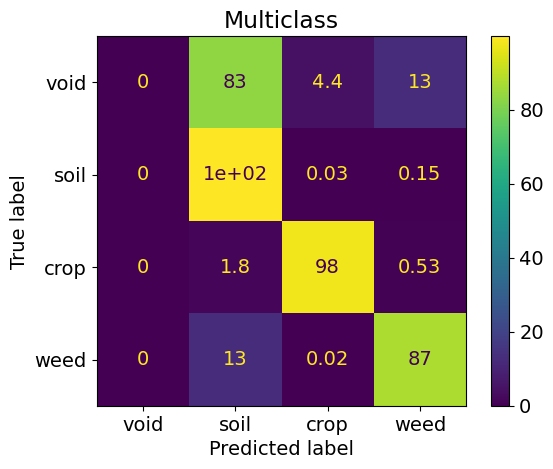

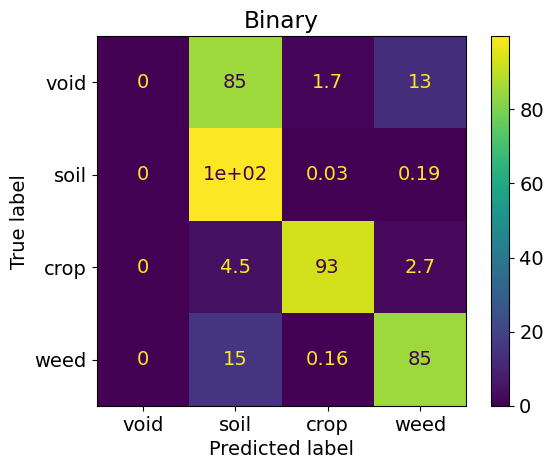

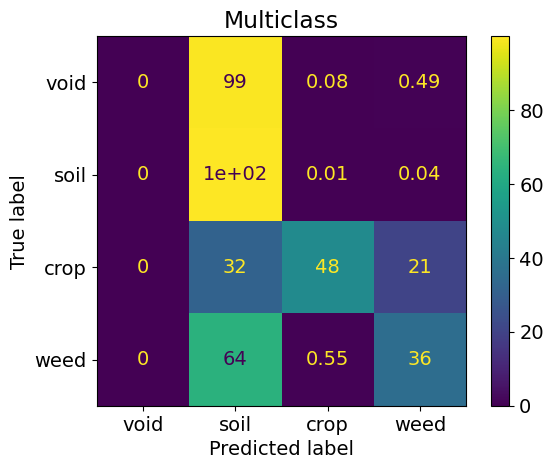

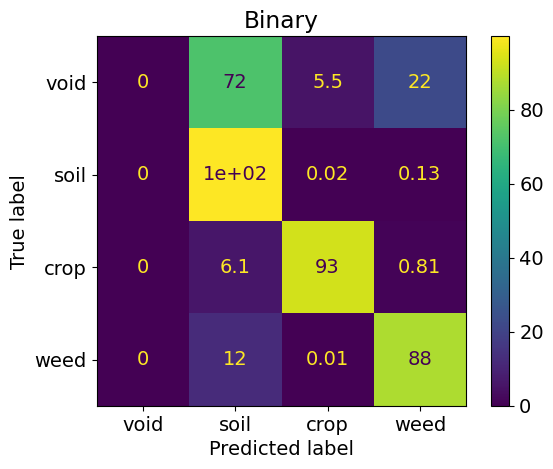

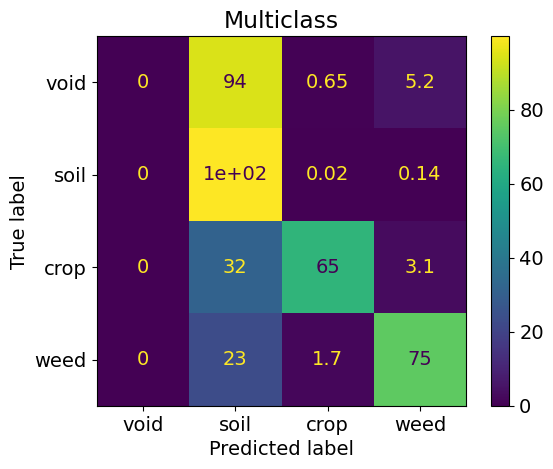

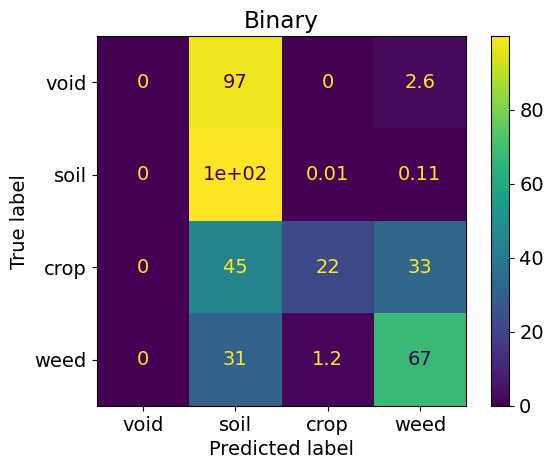

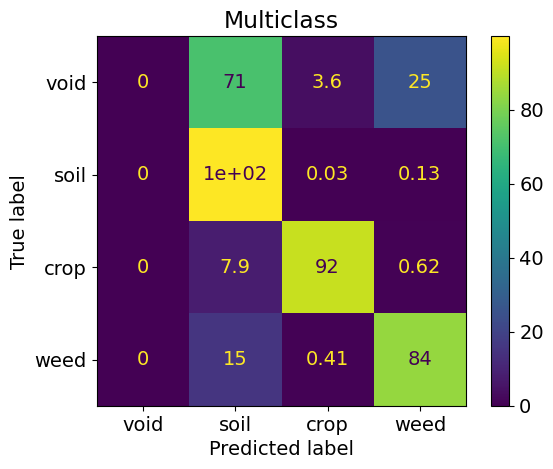

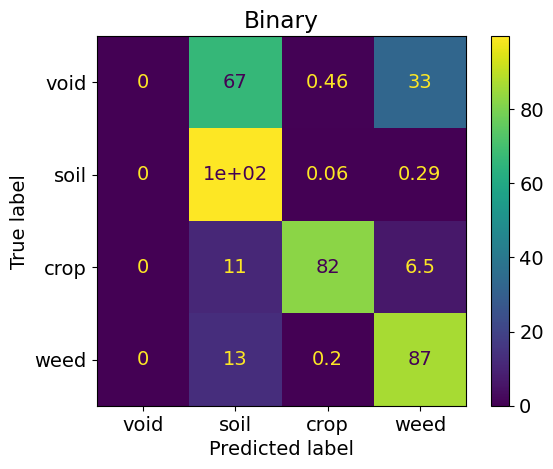

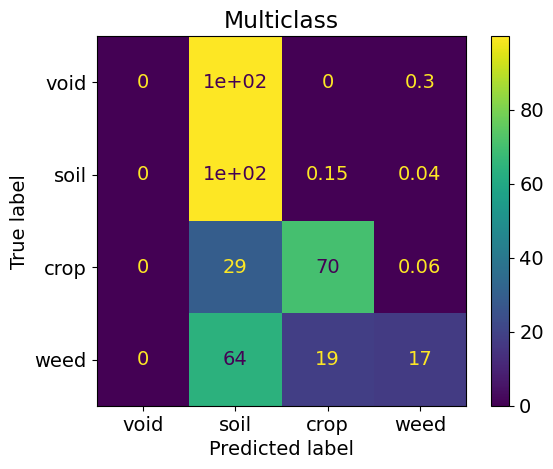

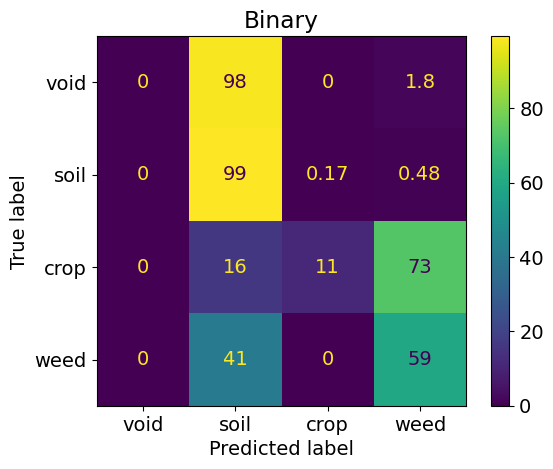

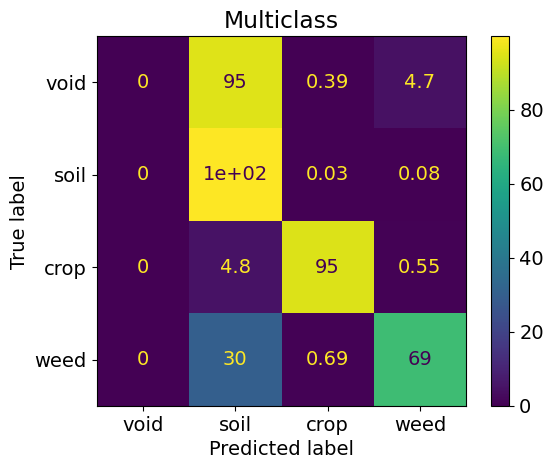

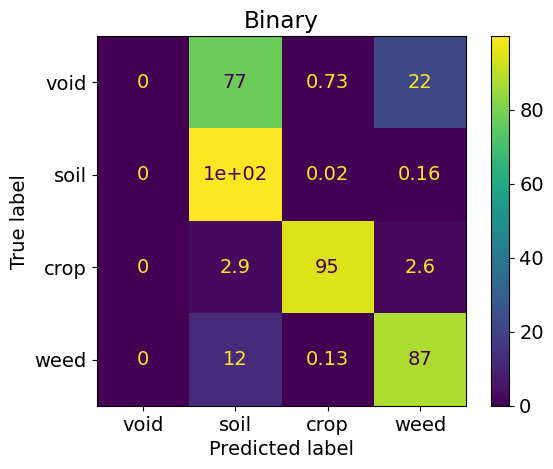

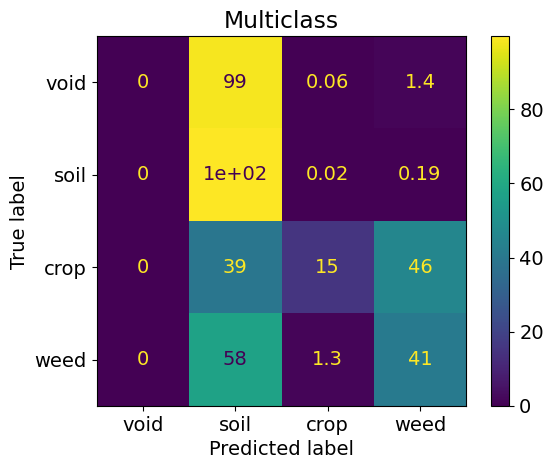

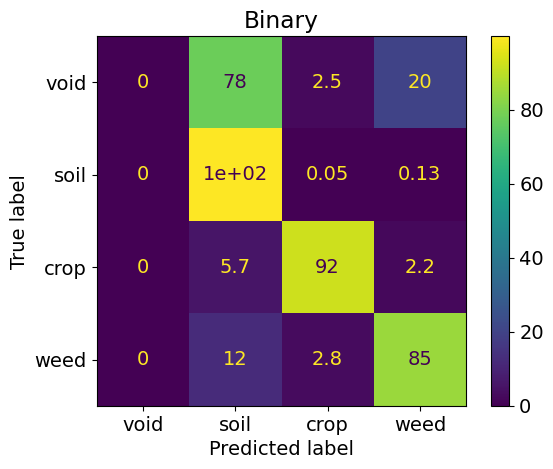

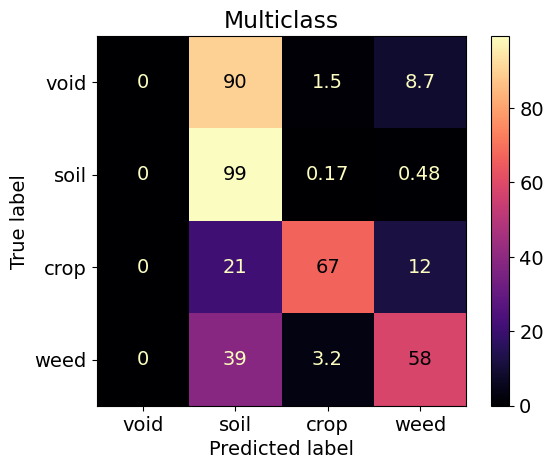

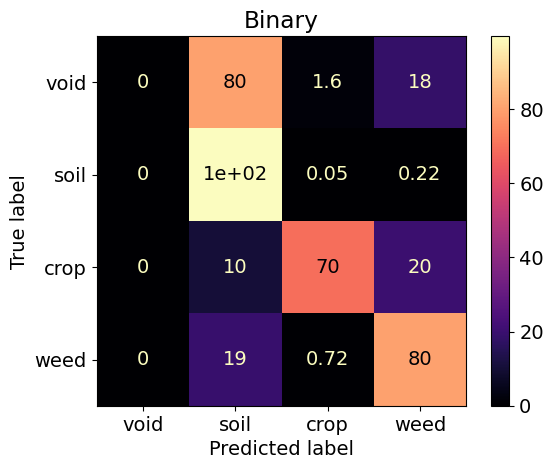

In [61]:
compute_and_visualize_confusion_matrices("../confusion_matrices/segformer-models-3-patience/")

Crop: broad_bean
Multiclass absolute confusion matrix: 
[[        0    153693      8060     23213]
 [        0 766382102    215051   1166610]
 [        0     77146   4120592     21583]
 [        0   1415875      1790   9825485]]
Binary absolute confusion matrix: 
[[        0    133922      6835     44209]
 [        0 766155592    236155   1372016]
 [        0     92591   4052341     74389]
 [        0   1183202      3870  10056078]]
Multiclass percentage confusion matrix: 
[[ 0.   83.09  4.36 12.55]
 [ 0.   99.82  0.03  0.15]
 [ 0.    1.83 97.66  0.51]
 [ 0.   12.59  0.02 87.39]]
Binary percentage confusion matrix: 
[[ 0.   72.4   3.7  23.9 ]
 [ 0.   99.79  0.03  0.18]
 [ 0.    2.19 96.04  1.76]
 [ 0.   10.52  0.03 89.44]]
Crop: common_buckwheat
Multiclass absolute confusion matrix: 
[[        0    158223      4565     34707]
 [        0 702605859    145410    942064]
 [        0    134862   2235040     10672]
 [        0   1513280      9592   9722526]]
Binary absolute confusion matrix

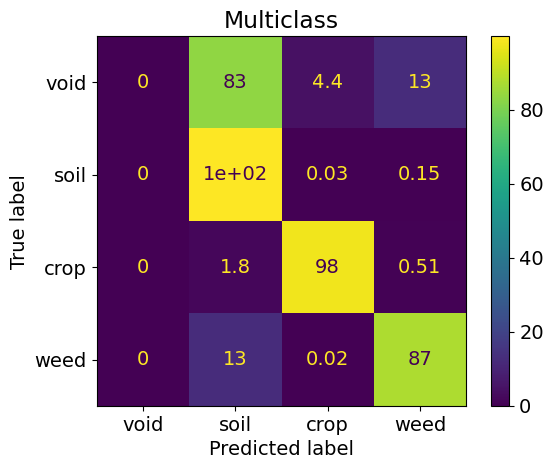

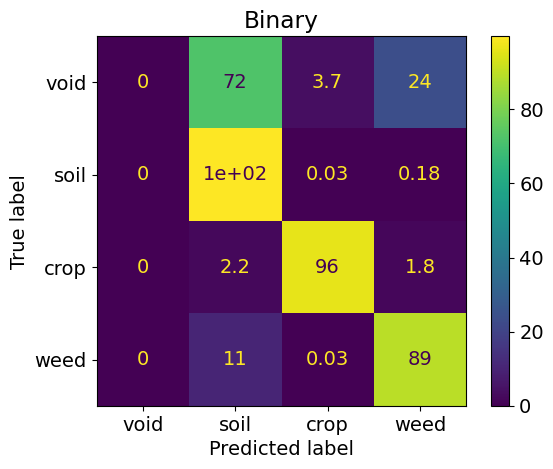

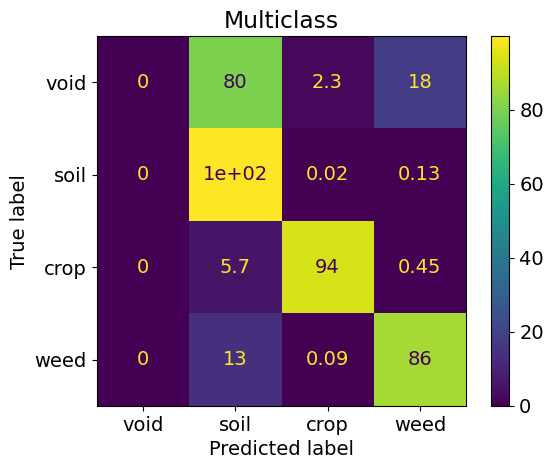

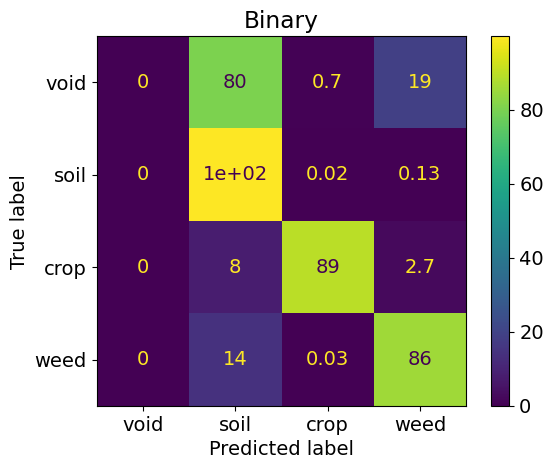

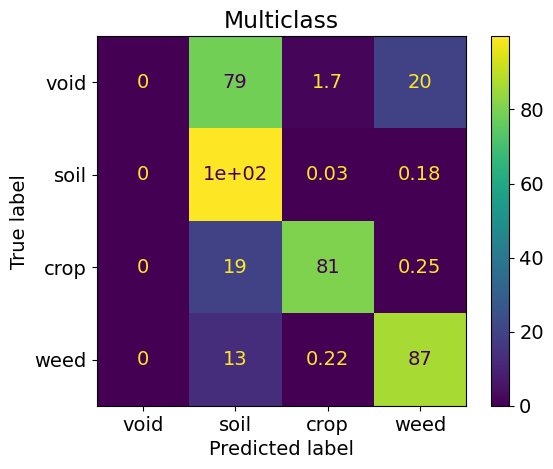

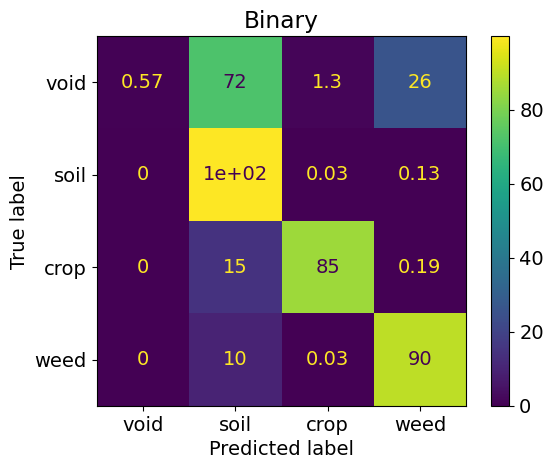

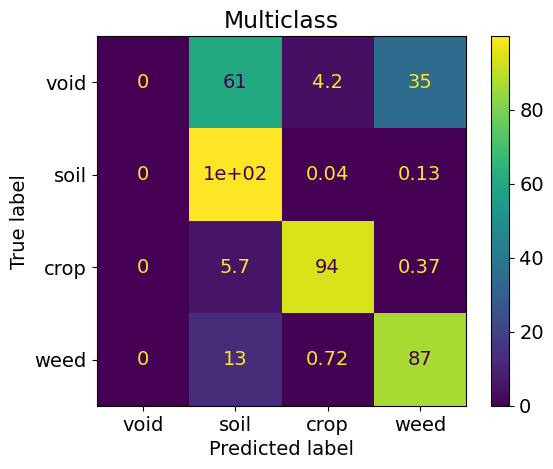

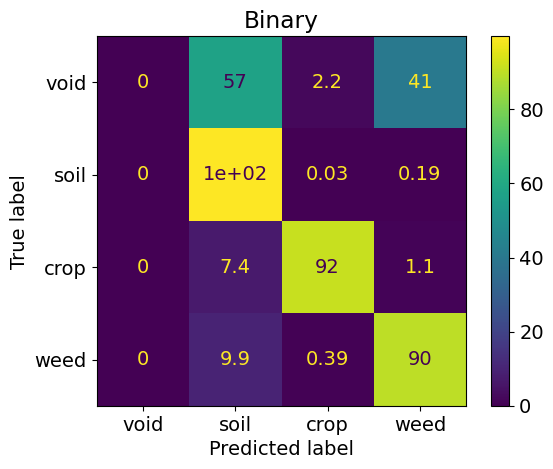

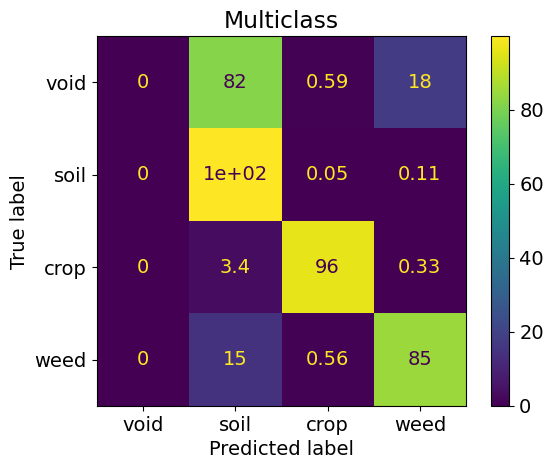

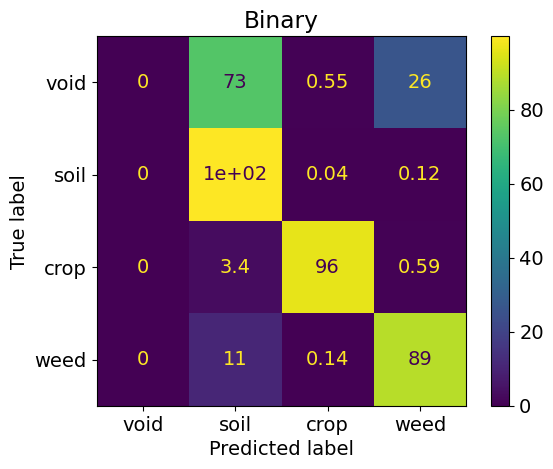

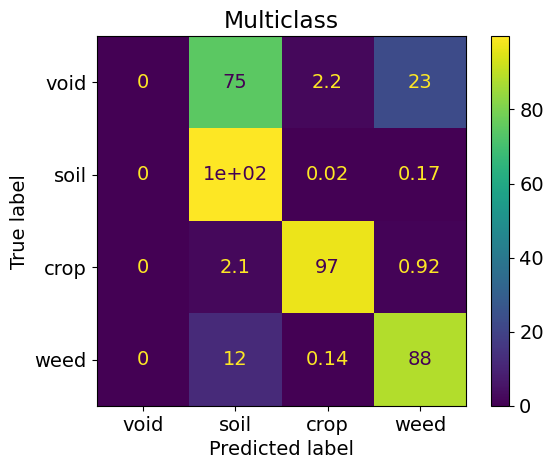

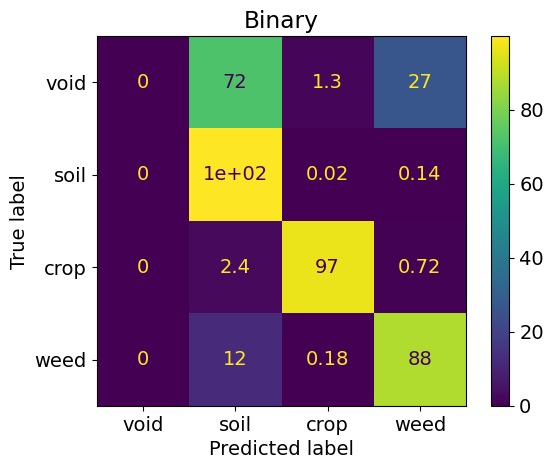

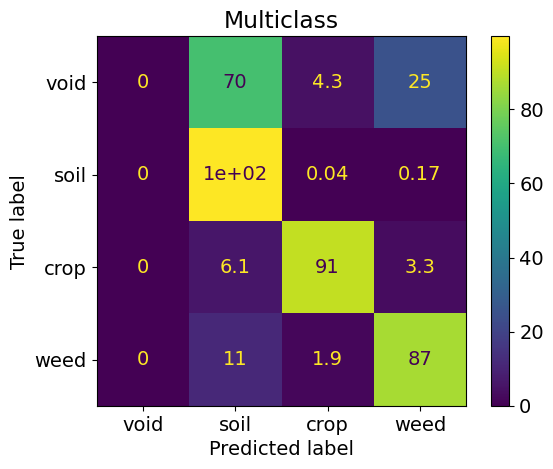

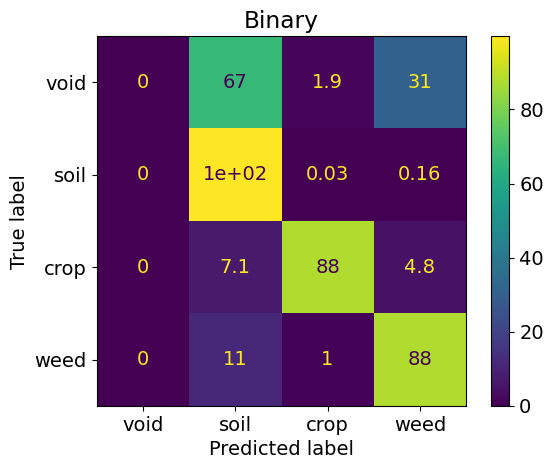

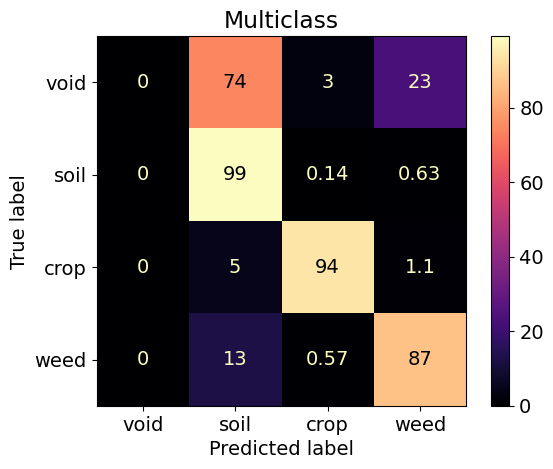

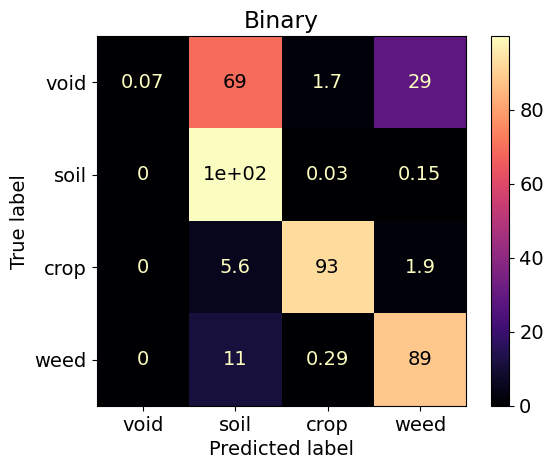

In [62]:
compute_and_visualize_confusion_matrices("../confusion_matrices/segformer-models-5-patience/")

Crop: broad_bean
Multiclass absolute confusion matrix: 
[[        0    151096      7213     26657]
 [        0 766370299    277318   1116146]
 [        0     54066   4135924     29331]
 [        0   1634136     73295   9535719]]
Binary absolute confusion matrix: 
[[    42358    110764      6721     25123]
 [    17796 766659583    145532    940852]
 [     1261     80298   4111283     26479]
 [     4099   1047197      1156  10190698]]
Multiclass percentage confusion matrix: 
[[ 0.   81.69  3.9  14.41]
 [ 0.   99.82  0.04  0.15]
 [ 0.    1.28 98.02  0.7 ]
 [ 0.   14.53  0.65 84.81]]
Binary percentage confusion matrix: 
[[22.9  59.88  3.63 13.58]
 [ 0.   99.86  0.02  0.12]
 [ 0.03  1.9  97.44  0.63]
 [ 0.04  9.31  0.01 90.64]]
Crop: common_buckwheat
Multiclass absolute confusion matrix: 
[[     5993    164278      1699     25525]
 [     1120 702639554    110715    941944]
 [      522    154492   2215714      9846]
 [        0   1636798     13497   9595103]]
Binary absolute confusion matrix

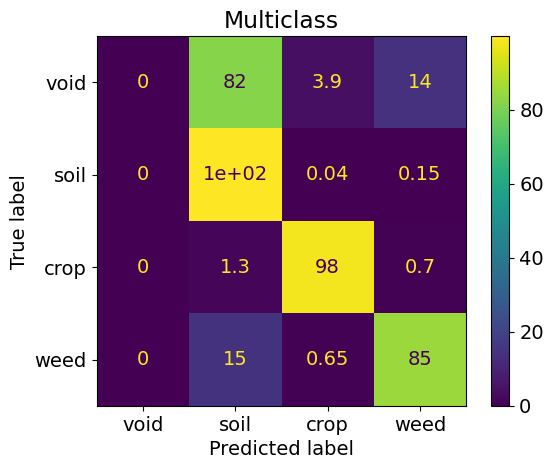

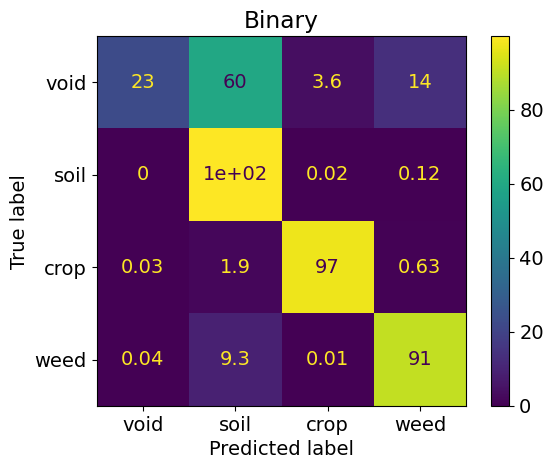

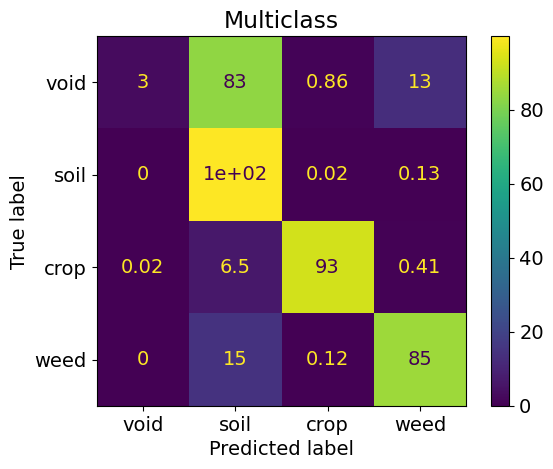

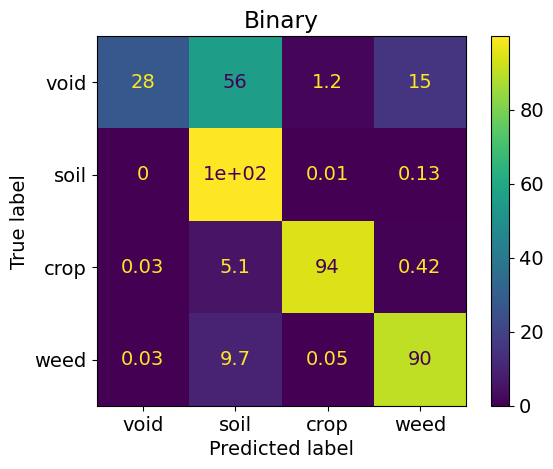

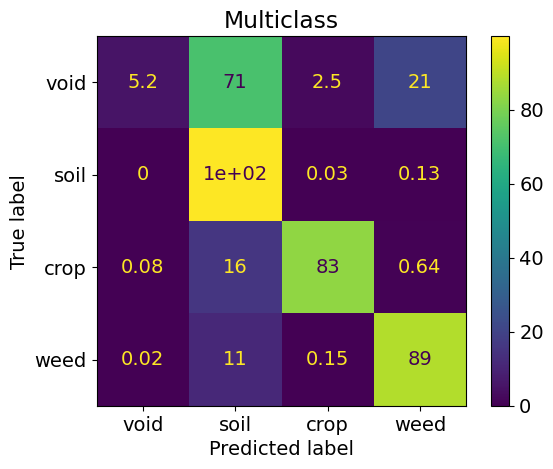

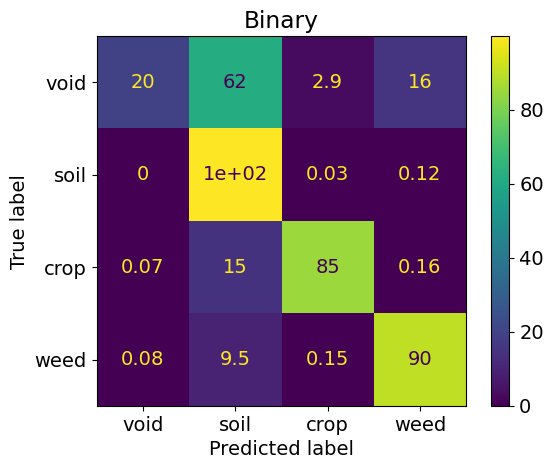

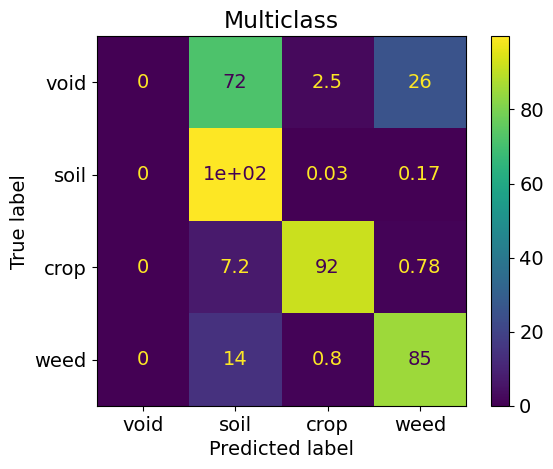

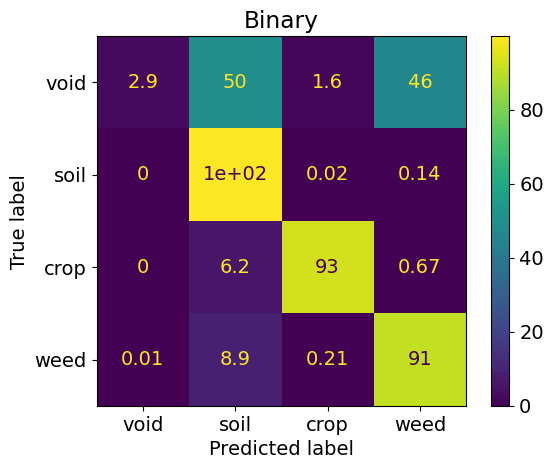

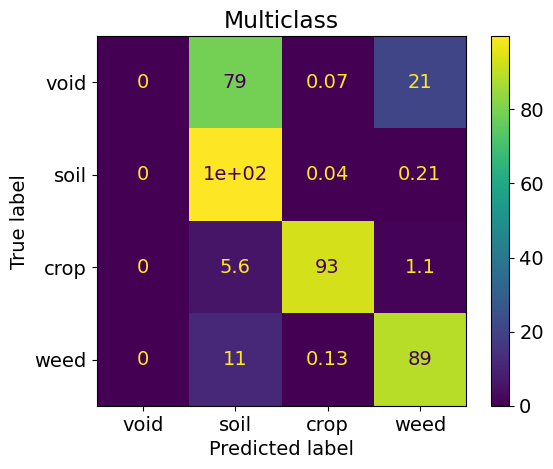

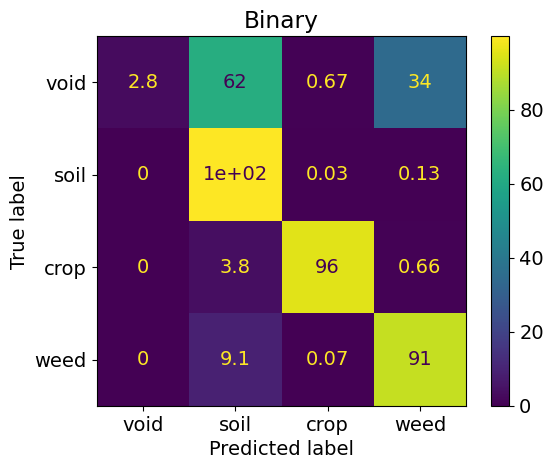

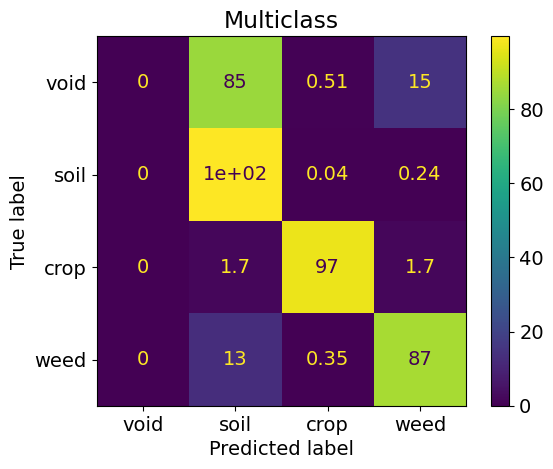

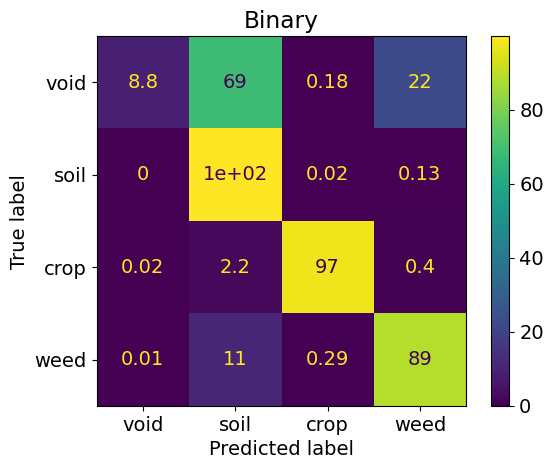

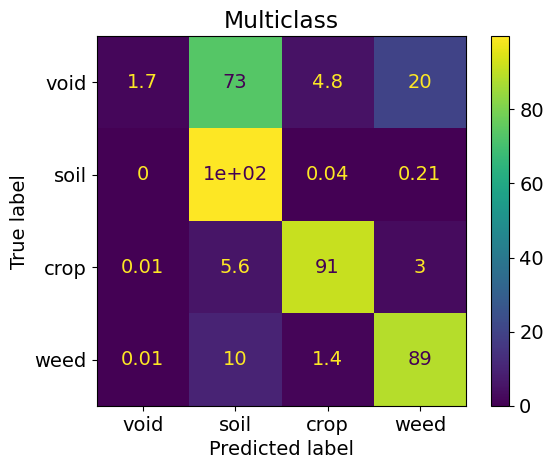

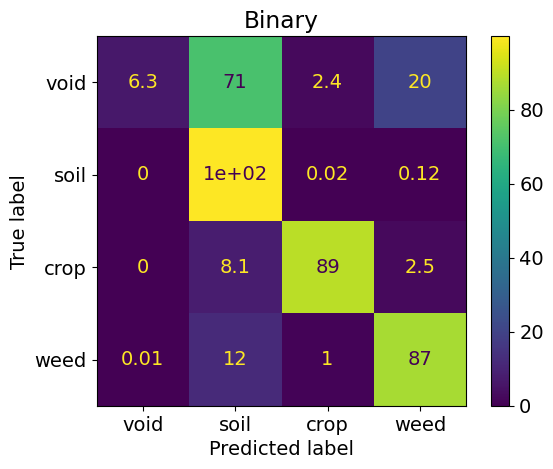

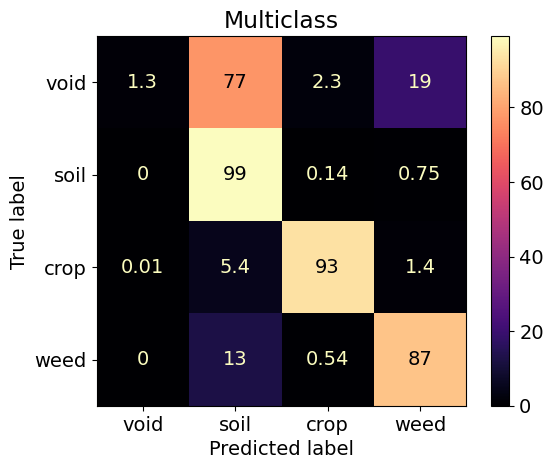

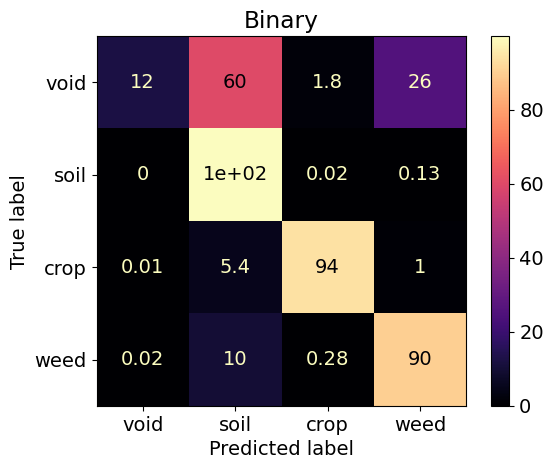

In [63]:
compute_and_visualize_confusion_matrices("../confusion_matrices/upernet-swin-models-3-patience/")

Crop: broad_bean
Multiclass absolute confusion matrix: 
[[    19339    120246      7615     37766]
 [     9002 766269773    181725   1303263]
 [      443     72001   4125534     21343]
 [     5167   1071744      6515  10159724]]
Binary absolute confusion matrix: 
[[    31717    110340      8063     34846]
 [    13671 766753442    112781    883869]
 [      584    105993   4087138     25606]
 [     3169   1091530      2788  10145663]]
Multiclass percentage confusion matrix: 
[[10.46 65.01  4.12 20.42]
 [ 0.   99.81  0.02  0.17]
 [ 0.01  1.71 97.78  0.51]
 [ 0.05  9.53  0.06 90.36]]
Binary percentage confusion matrix: 
[[17.15 59.65  4.36 18.84]
 [ 0.   99.87  0.01  0.12]
 [ 0.01  2.51 96.87  0.61]
 [ 0.03  9.71  0.02 90.24]]
Crop: common_buckwheat
Multiclass absolute confusion matrix: 
[[    45799    120112      2759     28825]
 [    32486 702304486    221534   1134827]
 [     5548     78241   2294191      2594]
 [    11411   1100711       734  10132542]]
Binary absolute confusion matrix

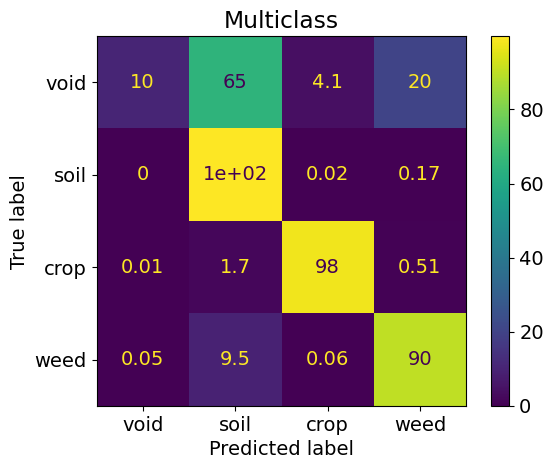

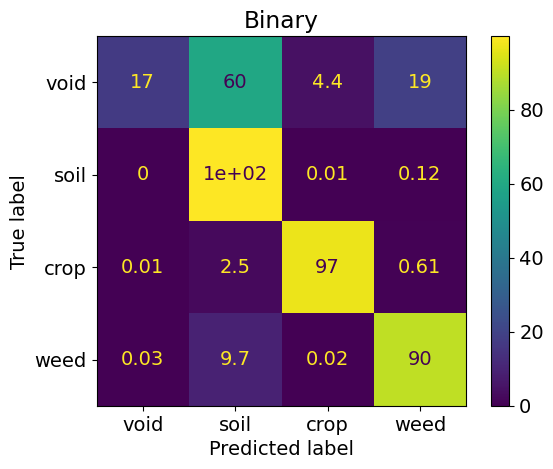

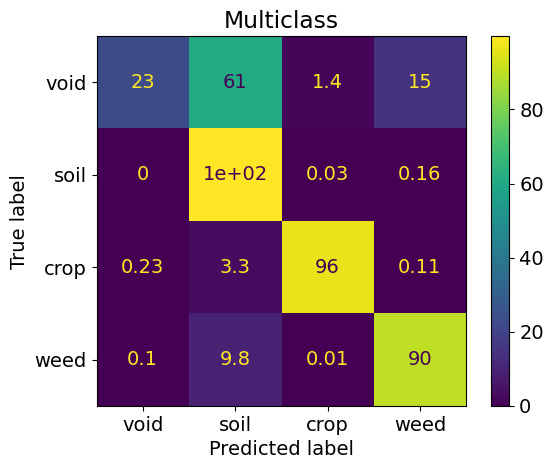

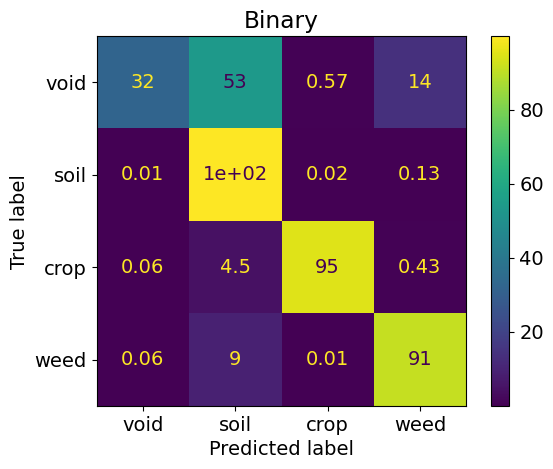

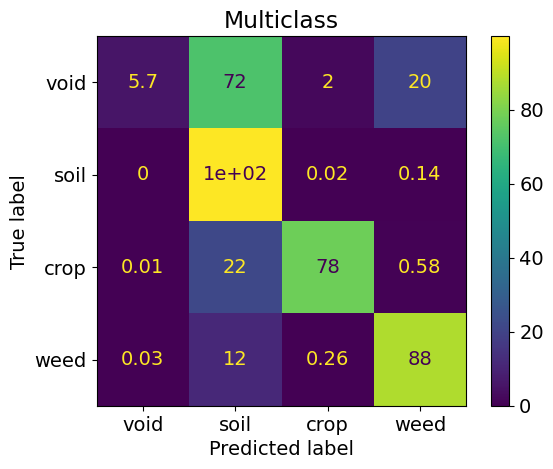

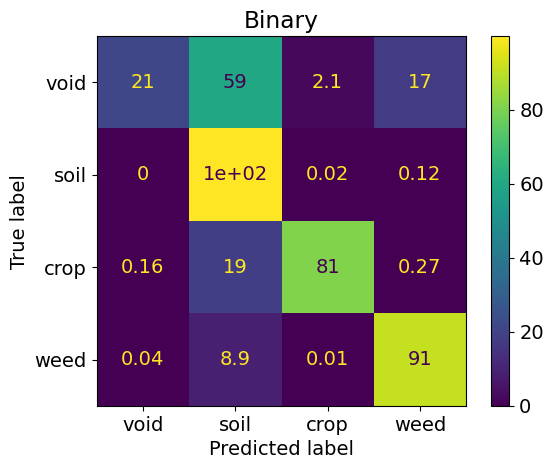

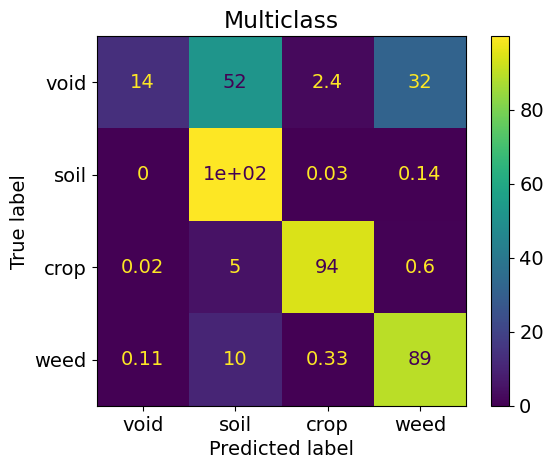

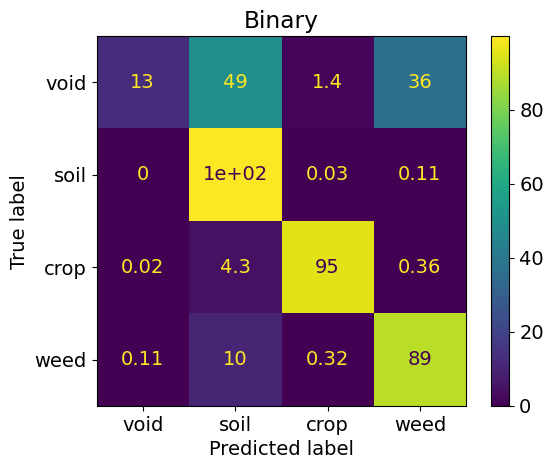

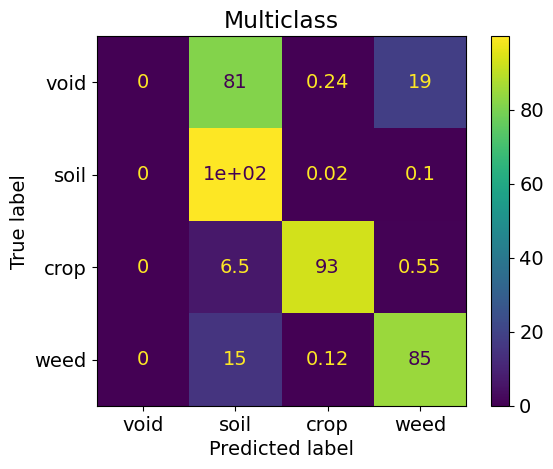

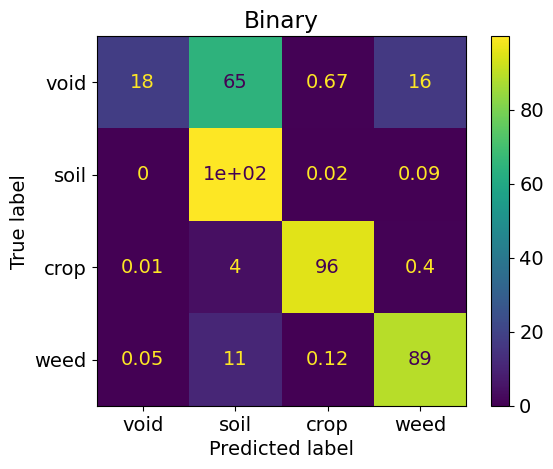

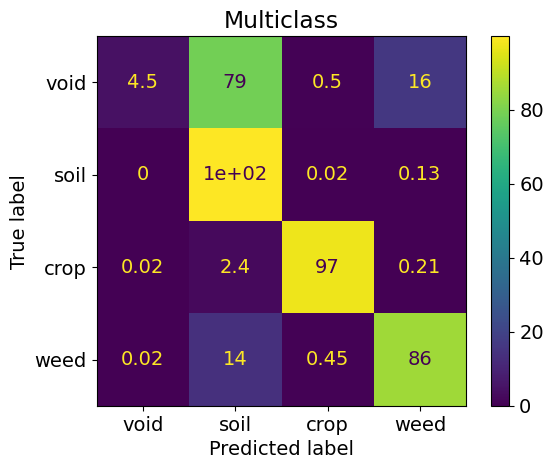

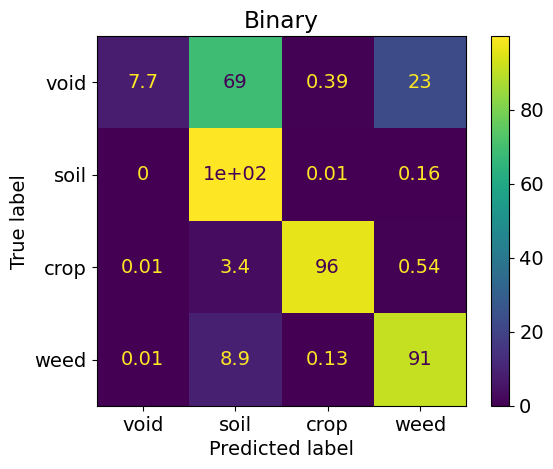

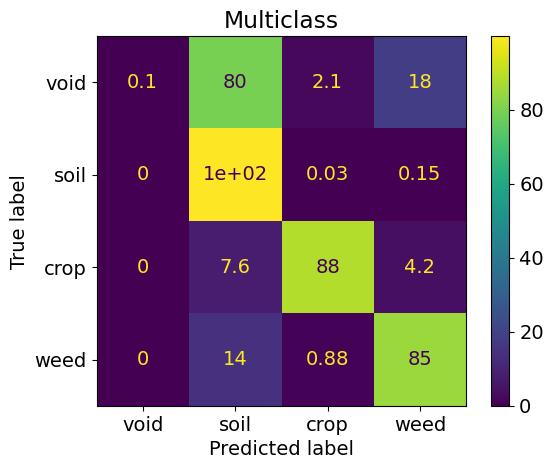

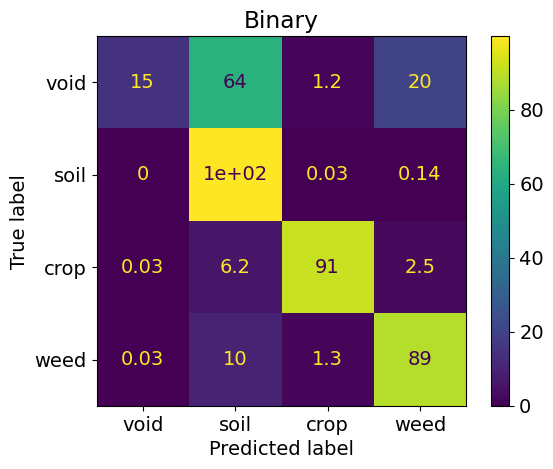

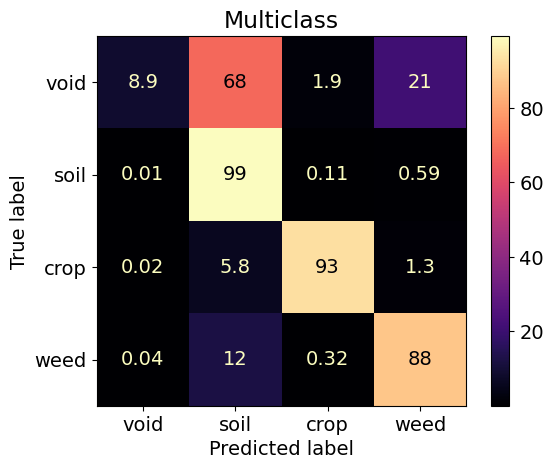

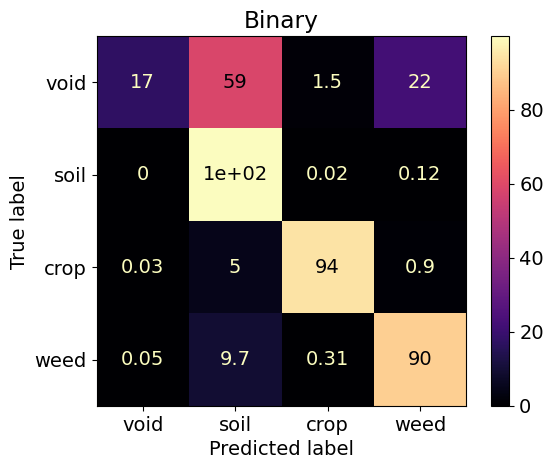

In [64]:
compute_and_visualize_confusion_matrices("../confusion_matrices/upernet-swin-models-5-patience/")